# **中古車価格予測に関するポートフォリオ（Pythonでの予測分析）**
Author - 藤弥大樹  
Contact - fzeabk5b@i.softbank.jp
***
# **目的**
世界中で自動車のEV化が加速しています。日本でも2030年までに新車販売される自動車を全て電動車とする方針が定められています。そんな中ガソリンスポーツカーの中古価格が現在高騰していることをご存知でしょうか。このプロジェクトは国産の内燃式自動車を対象とした中古車情報の既存のデータセットを調べることにより、  価格変動要因の分析と新車市場の将来中古価格予測を行うことを目的としています。 
# **使用されるテクノロジー/ライブラリ**
・Python 3  
・Jupyter  
・BeautifulSoup  
・Pandas  
・NumPy  
・Matplotlib  
・Seaborn  
・scikit-learn
# **方法論**
**1) スクレイピング** - デベロッパーツールによるHTML構成の把握と必要情報の選別、及び突き止めたテキスト記載場所からのデータ抽出と個々のページ構造を持つWebサイトの一括したデータ収集による適切なデータセットの構築  
  
**2) データクリーニング** - 乱雑で無秩序な生データの統制とそれぞれのデータセットにおける必要項目の数値化・統合、欠損値として扱うべきテキストの抽出及び構造化された特徴の利用による多段階の欠損値処理  
  
**3) 探索的データ分析** - 特徴ごとの相関関係視覚化と調査優先順位判別、要約統計及び回帰、分布、分散を使用したデータ視覚化を含む多次元的データ分析  
  
**4) 機械学習** - 決定木によるベースラインモデルの構築及びランダムフォレストによるアンサンブル学習を適用した回帰分析、K-分割交差検証を実装したデータ分割の工夫による性能評価指数の正確化とグリッドサーチを実装した高性能モデルを生み出すハイパーパラメータチューニング  
  
**5) 最良モデルの選択** - RMSE（平均二乗平方根誤差）が最小でR^2（決定係数）が最大であるモデルの選択  
  
**6) 将来予測** - 自動車EV化に向けたガソリン車販売状況変化のデータセット上における設定、及び経過年数ごとの新車モデル将来中古価格予測
  
**7) 機能の重要性** - 予測に対する影響の大小を特徴ごとに視覚化
# **目次**
### **1. ライブラリのインポートと各種設定**
### **2. 「価格.com」のスクレイピング（BeautifulSoup）**
    1. スクレイピング対象ページの紹介
    1. 中古車情報の取得
    2. グレード情報の取得
### **3. 取得したデータの整理（NumPy / Pandas）**
    1. 取得データの確認
    2. 「中古車データ」の整理
    3. 「グレードデータ」の整理
    4. 「中古車データ」と「グレードデータ」の統合
### **4. データの可視化（Matplotlib / Seaborn）**
    1. 販売中中古車の価格高騰率ランキング
    2. 各要素の相関
    3. 特徴ごとの個別調査
### **5. モデルの構築（scikit-learn）**
    1. 学習データの分割
    2. 機械学習モデルの構築
    3. モデルの検証
### **6. モデルの適用**
    1. テストデータの作成
    2. テストデータの処理
    3. 機械学習モデルの適用
    4. 予測に効いた重要な特徴
  
***
# **1. ライブラリのインポートと各種設定**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import requests
import re
import random
from bs4 import BeautifulSoup
from time import sleep
from retry import retry
from IPython.display import HTML
from statistics import mode

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

***
# **2. 「価格.com」のスクレイピング（BeautifulSoup）**
### **---- スクレイピイング対象ページ ----**
中古車情報を取得します。  
「価格.com中古車」については、以下のリンクをご参照下さい。  
▼一覧ページ  
[価格.com (トヨタ カムリ) ](https://kakaku.com/kuruma/used/spec/Maker=1/Model=30042/Page=1/)  
▼詳細ページ  
[価格.com (トヨタ カムリ WSレザーパッケージ)](https://kakaku.com/kuruma/used/item/26671455/)  
  
上記で取得した情報に加え、新車価格とその他グレード情報を取得します。  
「価格.comグレード」については、以下のリンクをご参照下さい。  
▼グレード一覧ページ  
[価格.com (トヨタ カムリ 2017年モデル) ](https://kakaku.com/item/K0000980810/catalog/)  
▼グレード詳細ページ  
[価格.com (トヨタ カムリ 2017年モデル X) ](https://kakaku.com/item/K0000980810/catalog/GradeID=50579/)
### **---- 中古車情報のスクレイピング ----**

In [49]:
@retry(tries=3, delay=5, backoff=2)
def get_html(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "html.parser")
    return soup

def parse_car_detail_info(car_url):
    data = {}   
    soup2 = get_html(car_url)
    data["名称"] = soup2.find("h3").getText().strip()
    data["価格"] = soup2.find("span", {"class": "priceTxt"}).find("span").getText().strip()
    for tr in soup2.find("table", {"class": "specList"}).findAll("tr"):
        data[tr.find("th").getText().strip()] = tr.find("td").getText().strip()
    dt = soup2.find("div", {"class": "carinfoArea"}).findAll("dt")
    dd = soup2.find("div", {"class": "carinfoArea"}).findAll("dd")
    for i, value in enumerate(dt):
        data[value.getText().strip()] = dd[i].getText().strip()
    data["モデル"] = soup2.find(class_="c-box-regularNote_item c-box-regularNote_item-nest").getText().strip()
    data["メーカー"] = soup2.find("title").getText().strip()
    return data
 
def check_next_page(soup):
    if soup.find("li", {"class": "next"}):
        return 1
    else:
        return 0
    
all_data = [] 
url_list = [
    # トヨタ
    "https://kakaku.com/kuruma/used/spec/Maker=1/Model=30042/Page={}", #カムリ
    "https://kakaku.com/kuruma/used/spec/Maker=1/Model=30099/Page={}", #スープラ
    "https://kakaku.com/kuruma/used/spec/Maker=1/Model=33324/Page={}", #カローラスポーツ
    "https://kakaku.com/kuruma/used/spec/Maker=1/Model=30069/Prefecture=1,2,9,17/Page={}", #クラウンアスリート
    "https://kakaku.com/kuruma/used/spec/Maker=1/Model=30069/Prefecture=24,29,36,42,47/Page={}",
    "https://kakaku.com/kuruma/used/spec/Maker=1/Model=31761/Prefecture=9/Page={}", #86
    "https://kakaku.com/kuruma/used/spec/Maker=1/Model=31761/Prefecture=1,2,17,24,29,36,42,47/Page={}",
    "https://kakaku.com/kuruma/used/spec/Maker=1/Model=33416/Page={}", #GRヤリス
    "https://kakaku.com/kuruma/used/spec/Maker=1/Model=30177/Prefecture=1,2,9/Page={}", #マークX
    "https://kakaku.com/kuruma/used/spec/Maker=1/Model=30177/Prefecture=17,24,29,36,42,47/Page={}",
    # ホンダ   
    "https://kakaku.com/kuruma/used/spec/Maker=2/Model=30238/Page={}/", # シビック
    "https://kakaku.com/kuruma/used/spec/Maker=2/Model=30241/Page={}", #シビックタイプR
    "https://kakaku.com/kuruma/used/spec/Maker=2/Model=33154/Page={}", #S660
    "https://kakaku.com/kuruma/used/spec/Maker=2/Model=30213/Page={}", #アコード
    "https://kakaku.com/kuruma/used/spec/Maker=2/Model=30204/Page={}", #NSX
    "https://kakaku.com/kuruma/used/spec/Maker=2/Model=30205/Page={}", #S2000
    "https://kakaku.com/kuruma/used/spec/Maker=2/Model=30222/Page={}", #インテグラ
    # 日産
    "https://kakaku.com/kuruma/used/spec/Maker=3/Model=30330/Prefecture=1,2,9/Page={}", #スカイライン
    "https://kakaku.com/kuruma/used/spec/Maker=3/Model=30330/Prefecture=17,24,29,36,42,47/Page={}",
    "https://kakaku.com/kuruma/used/spec/Maker=3/Model=30372/Page={}", #フーガ
    "https://kakaku.com/kuruma/used/spec/Maker=3/Model=30374/Page={}", #フェアレディZ
    "https://kakaku.com/kuruma/used/spec/Maker=3/Model=30284/Page={}", #GTR
    # 三菱
    "https://kakaku.com/kuruma/used/spec/Maker=4/Model=30493/Page={}", #ランサーエボリューション
    # マツダ
    "https://kakaku.com/kuruma/used/spec/Maker=5/Model=33354/Page={}", #mazda3
    "https://kakaku.com/kuruma/used/spec/Maker=5/Model=30516/Page={}", #アクセラ
    "https://kakaku.com/kuruma/used/spec/Maker=5/Model=30517/Page={}", #アクセラスポーツ
    "https://kakaku.com/kuruma/used/spec/Maker=5/Model=30575/Page={}", #ロードスター
    "https://kakaku.com/kuruma/used/spec/Maker=5/Model=33250/Page={}", #ロードスターRF
    "https://kakaku.com/kuruma/used/spec/Maker=5/Model=30515/Page={}", #RX-8
    # スバル
    "https://kakaku.com/kuruma/used/spec/Maker=6/Model=33125/Page={}", #WRXS4
    "https://kakaku.com/kuruma/used/spec/Maker=6/Model=31675/Page={}", #WRXSTI
    "https://kakaku.com/kuruma/used/spec/Maker=6/Model=31823/Page={}", #WRXSTI5door
    "https://kakaku.com/kuruma/used/spec/Maker=6/Model=33084/Prefecture=1,2,9/Page={}", #レヴォーグ
    "https://kakaku.com/kuruma/used/spec/Maker=6/Model=33084/Prefecture=17,24,29,36,42,47/Page={}",
    "https://kakaku.com/kuruma/used/spec/Maker=6/Model=30609/Page={}", #レガシィB4
    "https://kakaku.com/kuruma/used/spec/Maker=6/Model=31805/Prefecture=1,2,9/Page={}", #インプレッサスポーツ
    "https://kakaku.com/kuruma/used/spec/Maker=6/Model=31805/Prefecture=17,24,29,36,42,47/Page={}",
    "https://kakaku.com/kuruma/used/spec/Maker=6/Model=31762/Page={}", #BRZ
    # レクサス
    "https://kakaku.com/kuruma/used/spec/Maker=10/Model=30735/Prefecture=1,2,9/Page={}", #LS
    "https://kakaku.com/kuruma/used/spec/Maker=10/Model=30735/Prefecture=17,24,29,36,42,47/Page={}",
    "https://kakaku.com/kuruma/used/spec/Maker=10/Model=30733/Page={}", #IS
    "https://kakaku.com/kuruma/used/spec/Maker=10/Model=33278/Page={}", #LC
    "https://kakaku.com/kuruma/used/spec/Maker=10/Model=33407/Page={}", #LCコンバーチブル
    "https://kakaku.com/kuruma/used/spec/Maker=10/Model=33132/Page={}", #RC
    "https://kakaku.com/kuruma/used/spec/Maker=10/Model=33134/Page={}", #RCF
    "https://kakaku.com/kuruma/used/spec/Maker=10/Model=30728/Page={}", #ES
]
 
for url in url_list:
    for page in range(1, 61):                 
        soup = get_html(url.format(page)) 
        for item in soup.findAll("div", {"class": "ucItemBox"}):
            car_url = "https://kakaku.com" + item.find("a").get("href")                         
            all_data.append(parse_car_detail_info(car_url))
            sleep(1)
        
df = pd.DataFrame(all_data)
df.to_pickle("./Individuality.pkl")

### **---- グレード情報のスクレイピング ----**

In [273]:
@retry(tries=3, delay=5, backoff=2)
def get_html(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "html.parser")
    return soup
 
def parse_car_detail_info(car_url):
    data = {}
    soup2 = get_html(car_url) 
    data["Model"] = soup2.find("h2").getText().strip()
    data["販売数"] = soup2.find("span", {"class": "p-main_link-item-value"}).find("span").getText().strip()
    data[soup2.find("th", not("ttl01")).getText().strip()] = soup2.find("td").getText().strip()
   
    th = soup2.findAll("th")
    td = soup2.findAll("td")
    remove3 = [th[0]]
    remove3.append(th[25])
    remove3.append(th[30])
    remove3.append(th[-40])
    remove3.append(th[-32])
    remove3.append(th[-27])
    remove3.append(th[-22])
    remove3.append(th[-11])
    remove3.append(th[-5])
    th2 = [i for i in th if i not in remove3]
    for i,value in enumerate(th2):
        data[value.getText().strip()] = td[i].getText().strip()
    return data
 
def check_next_page(soup):
    if soup.find("li", {"class": "next"}):
        return 1
    else:
        return 0
    
all_data = []
url_list = [
    # トヨタ
    "https://kakaku.com/item/K0000980810/catalog/", #カムリ
    "https://kakaku.com/item/K0000295926/catalog/",
    "https://kakaku.com/item/K0000286430/catalog/",
    "https://kakaku.com/item/K0000286429/catalog/",
    "https://kakaku.com/item/K0001120789/catalog/", #スープラ
    "https://kakaku.com/item/K0000286486/catalog/",
    "https://kakaku.com/item/K0001064309/catalog/", #カローラスポーツ
    "https://kakaku.com/item/K0000451834/catalog/", #クラウンアスリート
    "https://kakaku.com/item/K0000286437/catalog/", 
    "https://kakaku.com/item/K0000286436/catalog/",
    "https://kakaku.com/item/K0000286435/catalog/",
    "https://kakaku.com/item/K0000338443/catalog/", #86
    "https://kakaku.com/item/K0001287745/catalog/", #GRヤリス
    "https://kakaku.com/item/K0000287325/catalog/", #マークX
    "https://kakaku.com/item/K0000287324/catalog/",
    # ホンダ
    "https://kakaku.com/item/K0001374347/catalog/", #シビック
    "https://kakaku.com/item/K0000966426/catalog/",
    "https://kakaku.com/item/K0000286529/catalog/",
    "https://kakaku.com/item/K0000286528/catalog/",
    "https://kakaku.com/item/K0000966341/catalog/", #シビックタイプR
    "https://kakaku.com/item/K0000824720/catalog/",
    "https://kakaku.com/item/K0000286531/catalog/",
    "https://kakaku.com/item/K0000286530/catalog/",
    "https://kakaku.com/item/K0000764437/catalog/", #S660
    "https://kakaku.com/item/K0001235866/catalog/", #アコード
    "https://kakaku.com/item/K0000524927/catalog/",
    "https://kakaku.com/item/K0000286515/catalog/",
    "https://kakaku.com/item/K0000286514/catalog/",
    "https://kakaku.com/item/K0000903377/catalog/", #NSX
    "https://kakaku.com/item/K0000286511/catalog/",
    # 日産
    "https://kakaku.com/item/K0000286512/catalog/", #S2000
    "https://kakaku.com/item/K0000286523/catalog/", #インテグラ
    "https://kakaku.com/item/K0000658496/catalog/", #スカイライン
    "https://kakaku.com/item/K0000286568/catalog/",
    "https://kakaku.com/item/K0000286567/catalog/",
    "https://kakaku.com/item/K0000286596/catalog/", #フーガ
    "https://kakaku.com/item/K0000286595/catalog/",
    "https://kakaku.com/item/K0000286578/catalog/", #フェアレディZ
    "https://kakaku.com/item/K0000286577/catalog/",
    "https://kakaku.com/item/K0000286606/catalog/", #GT-R
    # 三菱
    "https://kakaku.com/item/K0000286630/catalog/", #ランサーエボリューション
    "https://kakaku.com/item/K0000286629/catalog/",
    # マツダ
    "https://kakaku.com/item/K0001159813/catalog/", #MAZDA3
    "https://kakaku.com/item/K0000584330/catalog/", #アクセラ
    "https://kakaku.com/item/K0000286677/catalog/",
    "https://kakaku.com/item/K0000286676/catalog/",
    "https://kakaku.com/item/K0000584329/catalog/", #アクセラスポーツ
    "https://kakaku.com/item/K0000287409/catalog/",
    "https://kakaku.com/item/K0000287408/catalog/",
    "https://kakaku.com/item/K0000758192/catalog/", #ロードスター
    "https://kakaku.com/item/K0000286673/catalog/",
    "https://kakaku.com/item/K0000286672/catalog/",
    "https://kakaku.com/item/K0000922633/catalog/", #ロードスターRF
    "https://kakaku.com/item/K0000286675/catalog/", #RX-8
    #　スバル
    "https://kakaku.com/item/K0000686319/catalog/", #WRX S4
    "https://kakaku.com/item/K0000686320/catalog/", #WRX STI
    "https://kakaku.com/item/K0000287961/catalog/", #WRX STI 4door
    "https://kakaku.com/item/K0000287433/catalog/", #WRX STI 5door
    "https://kakaku.com/item/K0001281697/catalog/", #レヴォーグ
    "https://kakaku.com/item/K0000608487/catalog/",
    "https://kakaku.com/item/K0000709680/catalog/", #レガシィB4
    "https://kakaku.com/item/K0000287218/catalog/",
    "https://kakaku.com/item/K0000287217/catalog/", 
    "https://kakaku.com/item/K0000287216/catalog/",
    "https://kakaku.com/item/K0000914961/catalog/", #インプレッサスポーツ
    "https://kakaku.com/item/K0000319107/catalog/",
    "https://kakaku.com/item/K0001353009/catalog/", #BRZ
    "https://kakaku.com/item/K0000338845/catalog/",
    # レクサス
    "https://kakaku.com/item/K0001006981/catalog/", #LS
    "https://kakaku.com/item/K0000287042/catalog/",
    "https://kakaku.com/item/K0000510760/catalog/", #IS
    "https://kakaku.com/item/K0000287041/catalog/",
    "https://kakaku.com/item/K0000952538/catalog/", #LC
    "https://kakaku.com/item/K0001267085/catalog/", #LCコンバーチブル
    "https://kakaku.com/item/K0000708217/catalog/", #RC
    "https://kakaku.com/item/K0000708221/catalog/", #RC F
    "https://kakaku.com/item/K0001100392/catalog/", #ES
]
 
for url in url_list:
    for page in range(1, 2):
        soup = get_html(url.format(page))
        for item in soup.findAll("td", {"class": "grade"}):
            car_url = "https://kakaku.com" + item.find("a").get("href")
            all_data.append(parse_car_detail_info(car_url))
            sleep(1)

df_spec = pd.DataFrame(all_data)
df_spec.to_pickle("./Specification.pkl")

***
# **3. 取得したデータの整理（NumPy / Pandas）**
### **---- 取得データの確認 ----**
#### **▼ 「中古車データ」**

In [2]:
df = pd.read_pickle("./Individuality.pkl")

remove_columns = []
for i in df.columns:
    if len(i) >= 100:
        remove_columns.append(i)
df = df.drop(remove_columns, axis=1)
df

,名称,価格,色,年式／初度登録,走行距離,地域,車検,修復歴,未使用車,ワンオーナー,禁煙車,保証,ミッション,ハンドル,全長,駆動方式,車台番号,全幅,排気量,記録簿,全高,ドア数,リサイクル料,車両重量,乗車定員,整備,燃費（JC08モード）,燃料,使用燃料,モデル,メーカー,評価・鑑定,年式／初度検査
0,カムリ ＷＳレザーパッケージ 登録済未使用車 ナビ バックカメラ 黒革,409.8,パールホワイト,令和3年(2021年),30km,京都府,2024/02,修復歴なし,○,−,○,"販売店保証付(無料保証 期限:2026年2月 距離:100,000km ※いずれかの条件に達...",CVT,右ハンドル,"4,910mm※1",4WD,519（下3桁）,"1,840mm※1",2500cc,記録簿あり,"1,455mm※1",4ドア,リ済別,"1,680kg※1",5名,法定整備付,24.6km/L※1,ハイブリッド,レギュラー※1,※1 「カムリ 2017年モデル WS レザーパッケージ E-Four」のカタログによる情報...,トヨタ カムリ ＷＳレザーパッケージ 登録済未使用車 ナビ バックカメラ 黒革 409.8万...,NaN,NaN
1,カムリ ＷＳ ハイブリッド 衝突被害軽減システム オートクルーズコントロール ＬＥＤヘッドラ...,345.0,プラチナホワイトパールマイカ,令和3年(2021年),931km,静岡県,2024/04,修復歴なし,−,○,−,販売店保証付(無料保証 期間:12ヵ月 距離:無制限 ※いずれかの条件に達するまで保証を適用...,AT,右ハンドル,"4,910mm※1",2WD,432（下3桁）,"1,840mm※1",2500cc,,"1,445mm※1",4ドア,リ済別,"1,570kg※1",5名,法定整備付,28.4km/L※1,ハイブリッド,レギュラー※1,※1 「カムリ 2017年モデル WS」のカタログによる情報です。実際の物件状態を保証するも...,トヨタ カムリ ＷＳ ハイブリッド 衝突被害軽減システム オートクルーズコントロール ＬＥＤ...,,NaN
2,カムリ Ｘ メモリーナビ バックカメラ 衝突被害軽減システム ＥＴＣ ＬＥＤヘッドランプ ワ...,328.9,シルバーＭ,令和3年(2021年),997km,山口県,2024/01,修復歴なし,−,○,−,販売店保証付(無料保証 期間:12ヵ月 距離:無制限 ※いずれかの条件に達するまで保証を適用...,AT,右ハンドル,"4,885mm※1",2WD,601（下3桁）,"1,840mm※1",2500cc,,"1,445mm※1",4ドア,リ済別,"1,540kg※1",5名,法定整備付,33.4km/L※1,ハイブリッド,レギュラー※1,※1 「カムリ 2017年モデル X」のカタログによる情報です。実際の物件状態を保証するもの...,トヨタ カムリ Ｘ メモリーナビ バックカメラ 衝突被害軽減システム ＥＴＣ ＬＥＤヘッドラ...,,NaN
3,カムリ ＷＳ ワンオーナー 純正ナビ ドラレコ バックカメラ ヘットアップディスプレイ パノ...,377.0,アティチュードブラックマイカ,令和3年(2021年),0.4万km,北海道,2024/03,修復歴なし,−,○,○,"販売店保証付(無料保証 期限:2025年3月 距離:100,000km ※いずれかの条件に達...",CVT,右ハンドル,"4,910mm※1",4WD,706（下3桁）,"1,840mm※1",2500cc,記録簿あり,"1,455mm※1",4ドア,リ済別,"1,660kg※1",5名,法定整備付,24.6km/L※1,ハイブリッド,レギュラー※1,※1 「カムリ 2017年モデル WS E-Four」のカタログによる情報です。実際の物件状...,トヨタ カムリ ＷＳ ワンオーナー 純正ナビ ドラレコ バックカメラ ヘットアップディスプレ...,NaN,NaN
4,カムリ Ｇレザーパッケージ ディーラー保証・走行距離無制限 社用車 サポカーＳ クルーズコン...,360.0,プラチナホワイトパールマイカ,令和3年(2021年),0.5万km,兵庫県,2024/03,修復歴なし,−,○,−,販売店保証付(無料保証 期間:12ヵ月 距離:無制限 ※いずれかの条件に達するまで保証を適用...,CVT,右ハンドル,"4,885mm※1",2WD,211（下3桁）,"1,840mm※1",2500cc,,"1,445mm※1",4ドア,リ済別,"1,600kg※1",5名,法定整備付,28.4km/L※1,ハイブリッド,レギュラー※1,※1 「カムリ 2017年モデル G レザーパッケージ」のカタログによる情報です。実際の物件...,トヨタ カムリ Ｇレザーパッケージ ディーラー保証・走行距離無制限 社用車 サポカーＳ クル...,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27440,ＥＳ３００ｈ ３００ｈ バージョンＬ ブラック,548.0,クロ,令和元年(2019年),2.7万km,福岡県,車検整備なし,修復歴なし,−,−,−,販売店保証なし,AT,右ハンドル,"4,975mm※1",2WD,622（下3桁）,"1,865mm※1",2500cc,,"1,455mm※1",4ドア,,"1,730kg※1",5名,法定整備なし,23.4km/L※1,ハイブリッド,レギュラー※1,※1 「ES 2018年モデル 300h Version L」のカタログによる情報です。実際...,レクサス ＥＳ３００ｈ ３００ｈ バージョンＬ ブラック 548.0万円 令和元年(201...,,NaN
27441,ＥＳ３００ｈ ３００ｈ Ｆスポーツ パール,508.0,パールホワイト,令和元年(2019年),2.8万km,福岡県,2022/12,修復歴なし,−,−,−,販売店保証なし,AT,右ハンドル,"4,975mm※1",2WD,070（下3桁）,"1,865mm※1",2500cc,,"1,455mm※1",4ドア,,"1,720kg※1",5名,法定整備なし,23.4km/L※1,ハイブリッド,レギュラー※1,※1 「ES 2018年モデル 300h F SPORT」のカタログによる情報です。実際の物...,レクサス ＥＳ３００ｈ ３００ｈ Ｆスポーツ パール 508.0万円 令和元年(2019年...,,NaN
27442,ＥＳ３００ｈ バージョンＬ,479.0,パールホワイト,令和元年(2019年),4.9万km,埼玉県,車検整備なし,修復歴なし,−,−,−,販売店保証なし,AT,右ハンドル,"4,975mm※1",2WD,175（下3桁）,"1,865mm※1",2500cc,,"1,455mm※1",4ドア,リ済別,"1,730kg※1",5名,法定整備なし,23.4km/L※1,ハイブリッド,レギュラー※1,※1 「ES 2018年モデル 300h Version L」のカタログによる情報です。実際...,レクサス ＥＳ３００ｈ バージョンＬ 479.0万円 令和元年(2019年) 埼玉県 中古車...,NaN,NaN
27443,ＥＳ３００ｈ ３００ｈ バージョンＬ サンルーフ／全方,529.8,パールホワイト,平成30年(2018年),2.2万km,福岡県,2023/12,修復歴なし,−,−,−,販売店保証なし,AT,右ハンドル,,2WD,781（下3桁）,,2500cc,,,4ドア,,,5名,法定整備なし,,ハイブリッド,,※ 掲載しているすべての情報は万全の保証をいたしかねます。,レクサス ＥＳ３００ｈ ３００ｈ バージョンＬ サンルーフ／全方 529.8万円 平成30年...,,NaN


#### **▼ 「グレードデータ」**

In [3]:
df_spec = pd.read_pickle("./Specification.pkl")
df_spec

,Model,販売数,新車価格,中古車価格,発売日,発売区分,新車販売状況,駆動方式,型式,燃料,動力分類,燃料タンク容量,排気量,トランスミッション,乗車定員,ドア数,シート列数,燃費（WLTCモード）,燃費（WLTCモード|市街地）,燃費（WLTCモード|郊外）,燃費（WLTCモード|高速道路）,WLTC Co2排出量,燃費（JC08モード）,燃費（10.15モード）,ハンドル位置,最小回転半径,最高出力(kW[PS]/rpm),最高トルク(N・m[kgf・m]/rpm),過給機,アイドリングストップ,総電力量(kWh),充電走行距離（km）,最高出力(kW[PS]),最高トルク(N・m[kgf・m]),200V充電時間,急速充電時間,全長,全幅,全高,ホイールベース,最低地上高（未積載時）,車両重量,車両総重量,室内長,室内高,ヘッドルーム 前,ヘッドルーム 後,荷室容量（リアシート立）,荷室容量（リアシート倒）,荷室容量 測定方式,リアシートまでの長さ,ホイールサイズ 前,ホイールサイズ 後,タイヤサイズ 前,タイヤサイズ 後,トレッド幅 前,トレッド幅 後,アルミホイール,スペアタイヤ,パンク修理キット,空気圧警告灯,燃費基準達成率,自動車税減税率,自動車重量税減税率,取得税減税率,環境性能割税率,自動車税,自動車重量税,自動車取得税,環境性能割
0,カムリ 2017年モデル X,33,348万円,,2021年2月1日,マイナーチェンジ,販売中,FF,6AA-AXVH70-AEXDB,レギュラー,ハイブリッド,50L,"2,487cc",-,5名,4ドア,2列,27.1km/L,22.9km/L,30.6km/L,27.1km/L,86.0g/km,,,右,5.7m,131[178]/5700,221[22.5]/3600,なし,標準装備,1kWh,,88[120],202[20.6],,,"4,885mm","1,840mm","1,445mm","2,825mm",145mm,"1,550kg","1,825kg","2,010mm","1,185mm",,,524L,,VDA,,16.0インチ 6.5J,16.0インチ 6.5J,205/65R16,205/65R16,"1,600mm","1,605mm",なし,オプション装備,標準装備,標準装備,,,100%,,非課税,"43,500円","30,000円",,0円
1,カムリ 2017年モデル X E-Four,1,368万円,,2021年2月1日,マイナーチェンジ,販売中,4WD,6AA-AXVH75-AEXDB,レギュラー,ハイブリッド,50L,"2,487cc",-,5名,4ドア,2列,21.6km/L,17.1km/L,24.3km/L,22.5km/L,107.0g/km,24.6km/L,,右,5.7m,131[178]/5700,221[22.5]/3600,なし,標準装備,2kWh,,,,,,"4,885mm","1,840mm","1,455mm","2,825mm",155mm,"1,620kg","1,895kg","2,010mm","1,185mm",,,480L,,VDA,,16.0インチ 6.5J,16.0インチ 6.5J,205/65R16,205/65R16,"1,600mm","1,610mm",なし,なし,標準装備,標準装備,令和2年度燃費基準 + 20%達成,,100%,,非課税,"43,500円","30,000円",,0円
2,カムリ 2017年モデル G,151,379万円,,2021年2月1日,マイナーチェンジ,販売中,FF,6AA-AXVH70-AEXNB,レギュラー,ハイブリッド,50L,"2,487cc",-,5名,4ドア,2列,24.3km/L,20.1km/L,27.2km/L,24.7km/L,96.0g/km,,,右,5.7m,131[178]/5700,221[22.5]/3600,なし,標準装備,1kWh,,88[120],202[20.6],,,"4,885mm","1,840mm","1,445mm","2,825mm",145mm,"1,580kg","1,855kg","2,010mm","1,185mm",,,524L,,VDA,,17.0インチ 7.5J,17.0インチ 7.5J,215/55R17,215/55R17,"1,590mm","1,595mm",標準装備,オプション装備,標準装備,標準装備,,,100%,,非課税,"43,500円","30,000円",,0円
3,カムリ 2017年モデル G E-Four,490,399万円,,2021年2月1日,マイナーチェンジ,販売中,4WD,6AA-AXVH75-AEXNB,レギュラー,ハイブリッド,50L,"2,487cc",-,5名,4ドア,2列,21.6km/L,17.1km/L,24.3km/L,22.5km/L,107.0g/km,24.6km/L,,右,5.7m,131[178]/5700,221[22.5]/3600,なし,標準装備,2kWh,,,,,,"4,885mm","1,840mm","1,455mm","2,825mm",155mm,"1,660kg","1,935kg","2,010mm","1,185mm",,,480L,,VDA,,17.0インチ 7.5J,17.0インチ 7.5J,215/55R17,215/55R17,"1,590mm","1,600mm",標準装備,なし,標準装備,標準装備,令和2年度燃費基準 + 20%達成,,100%,,非課税,"43,500円","30,000円",,0円
4,カムリ 2017年モデル G レザーパッケージ,93,436万円,,2021年2月1日,マイナーチェンジ,販売中,FF,6AA-AXVH70-AEXNB(L),レギュラー,ハイブリッド,50L,"2,487cc",-,5名,4ドア,2列,24.3km/L,20.1km/L,27.2km/L,24.7km/L,96.0g/km,,,右,5.9m,131[178]/5700,221[22.5]/3600,なし,標準装備,1kWh,,88[120],202[20.6],,,"4,885mm","1,840mm","1,445mm","2,825mm",145mm,"1,600kg","1,875kg","2,010mm","1,185mm",,,524L,,VDA,,18.0インチ 8.0J,18.0インチ 8.0J,235/45R18,235/45R18,"1,580mm","1,585mm",標準装備,オプション装備,標準装備,標準装備,,,100%,,非課税,"43,500円","30,000円",,0円
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,ES 2018年モデル 300h,17,590万円,,2018年10月24日,フルモデルチェンジ,販売終了,FF,6AA-AXZH10,レギュラー,ハイブリッド,50L,"2,487cc",CVT,5名,4ドア,2列,20.6km/L,16.6km/L,22.7km/L,21.4km/L,113.0g/km,23.4km/L,,右,5.8m,131[178]/5700,221[22.5]/3600,なし,標準装備,10kWh,,88[120],202[20.6],,,"4,975mm","1,865mm","1,455mm","2,870mm",145mm,"1,680kg","1,955kg","2,170mm","1,145mm",995mm,960mm,,,VDA,,17.0インチ 7.5J,17.0インチ 7.5J,215/55R17,215/55R17,"1,600mm","1,610mm",標準装備,オプション装備,標準装備,標準装備,令和2年度燃費基準 + 20%達成,75%,100%,,非課税,"43,500円","30,000円",,0円
2483,ES 2018年モデル 300h F SPORT,109,648万円,,2020年8月6日,マイナーチェンジ,販売終了,FF,6AA-AXZH11-AEXGB,レギュラー,ハイブリッド,50L,"2,487cc",-,5名,4ドア,2列,22.3km/L,18.1km/L,24.7km/L,23.1km/L,,25.1km/L,,右,5.9m,131[178]/5700,221[22.5]/3600,なし,標準装備,2kWh,,88[120],202[20.6],,,"4,975mm","1,865mm","1,455mm","2,870mm",145mm,"1,710kg","1,985kg","2,170mm","1,145mm",995mm,960mm,,,VDA,,19.0イン

### **---- 「中古車データ」の整理 ----**
#### **データの数値化**

In [4]:
df["年式／初度登録"] = df["年式／初度登録"].fillna(df["年式／初度検査"])
df["Model_year"] = df["年式／初度登録"].apply(lambda x: int(re.findall(r"[0-9]{4}", x)[0]) if len(re.findall(r"[0-9]{4}", x))!=0 else np.nan)
df["Model_year"] = df["Model_year"].astype(float)
df["Seling_price"] = df["価格"].replace("応談", np.nan)
df["Seling_price"] = df["Seling_price"].astype(float)

def convert_distance(value):
    if len(re.findall(r"[0-9.]+", value)) == 0:
        return 0
    else:      
        num = float(re.findall(r"[0-9.]+", value)[0])           
        if "万" in value:
            num = float(num) * 10000
    return num

df["Model"] = df["モデル"].apply(lambda x: str(re.findall(r"(?<=「).+(?=」)", x)[0]) if len(re.findall(r"(?<=「).+(?=」)", x))!=0 else np.nan)
df.loc[df["メーカー"].str.startswith("トヨタ"), "Maker"] = 1
df.loc[df["メーカー"].str.startswith("ホンダ"), "Maker"] = 2
df.loc[df["メーカー"].str.startswith("日産"), "Maker"] = 3
df.loc[df["メーカー"].str.startswith("三菱"), "Maker"] = 4
df.loc[df["メーカー"].str.startswith("マツダ"), "Maker"] = 5
df.loc[df["メーカー"].str.startswith("スバル"), "Maker"] = 6
df.loc[df["メーカー"].str.startswith("レクサス"), "Maker"] = 7
df.dropna(subset=["Seling_price", "Model_year"], how="any", inplace=True)

df["MT"] = df["ミッション"].apply(lambda x: 1 if x=="MT" else 0)
df["WD"] = df["駆動方式"].apply(lambda x: float(re.findall(r"[0-9]", x)[0]) if len(re.findall(r"[0-9]", x))!=0 else np.nan)
df["Displacement"] = df["排気量"].apply(lambda x: float(re.findall(r"[0-9]+", x)[0]) if len(re.findall(r"[0-9]+", x))!=0 else np.nan)

df.loc[df["色"].str.contains("ブラック|クロ|黒"), "Color"] = 1
df.loc[df["色"].str.contains("グレー|ソニック|グラファイト|ガンメタ|ガンＭ"), "Color"] = 2
df.loc[df["色"].str.contains("シルバー|アイス|スチール|銀"), "Color"] = 3
df.loc[df["色"].str.contains("ホワイト|シロ|白"), "Color"] = 4
df.loc[df["色"].str.contains("レッド|アカ|ワイン|赤|Ｒ"), "Color"] = 5
df.loc[df["色"].str.contains("ブルー|アオ|青"), "Color"] = 6
df.loc[df["色"].str.contains("イエロー|黄"), "Color"] = 7
df.loc[df["色"]=="パール", "Color"] = 4
df.loc[df["Color"].isnull(), "Color"] = 0

df.loc[df["色"].str.contains("パール|P"), "Brightness"] = 1 
df.loc[df["色"].str.contains("メタリック|M"), "Brightness"] = 2 
df.loc[df["Brightness"].isnull(), "Brightness"] = 0

df["Door"] = df["ドア数"].apply(lambda x: float(re.findall(r"[0-9]", x)[0]) if len(re.findall(r"[0-9]", x))!=0 else np.nan)

df["Capacity"] = df["乗車定員"].apply(lambda x: float(re.findall(r"[0-9]", x)[0]) if len(re.findall(r"[0-9]", x))!=0 else np.nan)

df["Length"] = df["全長"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan)
df["Length"] = df["Length"].str.replace(",","").astype(float)

df["Width"] = df["全幅"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan)
df["Width"] = df["Width"].str.replace(",","").astype(float)

df["Height"] = df["全高"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan)
df["Height"] = df["Height"].str.replace(",","").astype(float)

df["Weight"] = df["車両重量"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan)
df["Weight"] = df["Weight"].str.replace(",","").astype(float)

df.loc[df["燃料"]=="ハイブリッド", "Hybrid"] = 1
df.loc[~(df["燃料"]=="ハイブリッド"), "Hybrid"] = 0

df.loc[df["使用燃料"].str.contains("レギュラー"), "Fuel"] = 1
df.loc[df["使用燃料"].str.contains("ハイオク"), "Fuel"] = 2
df.loc[df["使用燃料"].str.contains("ディーゼル"), "Fuel"] = 3

df.loc[df["名称"].str.contains("台限定"), "Limited"] = 1
df.loc[~df["名称"].str.contains("台限定"), "Limited"] = 0

df["Age"] = 2022-df["Model_year"]

#### **"Model"の補正**

In [5]:
# トヨタ

df.loc[(df["Model"].isnull())&(df["名称"].str.contains("カムリ"))&(df["Model_year"]>2016)&(df["WD"]==4), "Model"] = "カムリ 2017年モデル WS E-Four"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("カムリ"))&(df["Model_year"]>2016)&(df["名称"].str.contains("Ｇ|G")), "Model"] = "カムリ 2017年モデル G"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("カムリ"))&(df["Model_year"]>2016)&(df["名称"].str.contains("ＷＳ|WS")), "Model"] = "カムリ 2017年モデル WS"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("カムリ"))&(df["Model_year"]>2016)&(df["名称"].str.contains("Ｘ|X")), "Model"] = "カムリ 2017年モデル X"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("カムリ"))&(df["Model_year"]>2016), "Model"] = "カムリ 2017年モデル G"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("カムリ"))&(df["Model_year"]>2010)&(df["Model_year"]<2017)&(df["名称"].str.contains("Ｇ|G")), "Model"] = "カムリ 2011年モデル ハイブリッド Gパッケージ"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("カムリ"))&(df["Model_year"]>2010)&(df["Model_year"]<2017), "Model"] = "カムリ 2011年モデル ハイブリッド レザーパッケージ"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("カムリ"))&(df["Model_year"]>2010)&(df["Model_year"]<2017), "Model"] = "カムリ 2011年モデル ハイブリッド"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("カムリ"))&(df["名称"].str.contains("G")), "Model"] = "カムリ 2017年モデル G E-Four"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("カムリ")), "Model"] = "カムリ 2017年モデル G"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("マークＸ|マークX"))&(df["Model_year"]>2008)&(df["WD"]==4), "Model"] = "マークX 2009年モデル 250G Four"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("マークＸ|マークX"))&(df["Model_year"]>2008)&(df["名称"].str.contains("３５０Ｓ　Ｇ’ｓ|３５０Ｓ　Ｇｓ")), "Model"] = "マークX 2009年モデル 350S G's"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("マークＸ|マークX"))&(df["Model_year"]>2008)&(df["Displacement"]>3400), "Model"] = "マークX 2009年モデル 350S"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("マークＸ|マークX"))&(df["Model_year"]>2008)&(df["Displacement"]>2400), "Model"] = "マークX 2009年モデル 250G"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("マークＸ|マークX"))&(df["Model_year"]<2009)&(df["Displacement"]>2400), "Model"] = "マークX 2004年モデル 250G"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("スープラ"))&(df["Model_year"]>2018)&(df["Displacement"]>2800), "Model"] = "スープラ 2019年モデル RZ"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("スープラ"))&(df["Model_year"]>2018)&(df["Displacement"]==2000), "Model"] = "スープラ 2019年モデル SZ-R"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("スープラ"))&(df["Model_year"]<2019)&(df["Displacement"]==3000)&(df["名称"].str.contains("Ｒ")), "Model"] = "スープラ 1993年モデル RZ-S"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("スープラ"))&(df["Model_year"]<2019)&(df["Displacement"]==3000)&(~df["名称"].str.contains("Ｒ")), "Model"] = "スープラ 1993年モデル SZ"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("スープラ"))&(df["Model_year"]<2019)&(df["Displacement"]<2100), "Model"] = "スープラ 1993年モデル 2.0GT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("スープラ"))&(df["Model_year"]<2019)&(df["Displacement"]>2400), "Model"] = "スープラ 1993年モデル 2.5GT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("カローラ"))&(df["Displacement"]>1700)&(df["名称"].str.contains("Ｚ|Z")), "Model"] = "カローラ スポーツ 2018年モデル HYBRID G Z"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("カローラ"))&(df["Displacement"]>1700)&(df["名称"].str.contains("X")), "Model"] = "カローラ スポーツ 2018年モデル HYBRID G X"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("カローラ"))&(df["Displacement"]>1700), "Model"] = "カローラ スポーツ 2018年モデル HYBRID G"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("カローラ"))&(df["Displacement"]==1200)&(df["WD"]==4), "Model"] = "カローラ スポーツ 2018年モデル G Z 4WD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("カローラ"))&(df["Displacement"]==1200)&(df["WD"]==2)&(df["名称"].str.contains("Ｚ|Z")), "Model"] = "カローラ スポーツ 2018年モデル G Z"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("カローラ"))&(df["Displacement"]==1200)&(df["WD"]==2)&(~df["名称"].str.contains("Ｚ|Z")), "Model"] = "カローラ スポーツ 2018年モデル G"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("カローラ")), "Model"] = "カローラ スポーツ 2018年モデル G Z"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["Model_year"]>2011)&(df["WD"]==4)&(df["名称"].str.contains("S"))&(df["名称"].str.contains("i")), "Model"] = "クラウン アスリート 2012年モデル 2.5 アスリートS i-Four"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["Model_year"]>2011)&(df["WD"]==4)&(df["名称"].str.contains("S"))&(~df["名称"].str.contains("i")), "Model"] = "クラウン アスリート 2012年モデル 2.5 アスリートS Four"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["Model_year"]>2011)&(df["WD"]==4)&(df["名称"].str.contains("G"))&(df["名称"].str.contains("i")), "Model"] = "クラウン アスリート 2012年モデル 2.5 アスリートG i-Four"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["Model_year"]>2011)&(df["WD"]==4), "Model"] = "クラウン アスリート 2012年モデル 2.5 アスリート i-Four"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["Model_year"]>2011)&(df["WD"]==2)&(df["名称"].str.contains("S"))&(df["Displacement"]>3400), "Model"] = "クラウン アスリート 2012年モデル 3.5 アスリートS"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["Model_year"]>2011)&(df["WD"]==2)&(df["名称"].str.contains("S"))&(df["Displacement"]>2400), "Model"] = "クラウン アスリート 2012年モデル 2.5 アスリートS"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["Model_year"]>2011)&(df["WD"]==2)&(df["名称"].str.contains("G"))&(df["Displacement"]>2400), "Model"] = "クラウン アスリート 2012年モデル 2.5 アスリートG"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["Model_year"]>2011)&(df["WD"]==2)&(df["名称"].str.contains("リミテッド"))&(df["Displacement"]>2400), "Model"] = "クラウン アスリート 2012年モデル ハイブリッド アスリートS J-FRONTIER Limited"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["Model_year"]>2011)&(df["WD"]==2)&(df["Displacement"]>2400), "Model"] = "クラウン アスリート 2012年モデル 2.5 アスリート"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["Model_year"]>2011)&(df["WD"]==2)&(df["Displacement"]<2100)&(df["名称"].str.contains("フロンティア")), "Model"] = "クラウン アスリート 2012年モデル S-T J-FRONTIER"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["Model_year"]>2011)&(df["WD"]==2)&(df["Displacement"]<2100)&(~df["名称"].str.contains("フロンティア")), "Model"] = "クラウン アスリート 2012年モデル S-T"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["WD"]==4)&(df["名称"].str.contains("60th")), "Model"] = "クラウン アスリート 2003年モデル 2.5 アスリートi-Four 60th スペシャルエディション"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["WD"]==4)&(df["名称"].str.contains("ナビパッケージ")), "Model"] = "クラウン アスリート 2008年モデル 2.5 アスリート i-Four ナビパッケージ"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["WD"]==4), "Model"] = "クラウン アスリート 2008年モデル 2.5 アスリート i-Four"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["Model_year"]<2012)&(df["Model_year"]>2002)&(df["WD"]==2)&(df["Displacement"]>3400), "Model"] = "クラウン アスリート 2008年モデル 3.5 アスリート"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["Model_year"]<2012)&(df["Model_year"]>2002)&(df["WD"]==2)&(df["Displacement"]>2400), "Model"] = "クラウン アスリート 2008年モデル 2.5 アスリート"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["WD"]==2)&(df["Displacement"]==3000), "Model"] = "クラウン アスリート 2003年モデル 3.0 アスリート"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["Displacement"]==3500), "Model"] = "クラウン アスリート 2008年モデル 3.5 アスリート"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["名称"].str.contains("アニバーサリー")), "Model"] = "クラウン アスリート 2008年モデル 2.5 アスリート Anniversary Edition"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["名称"].str.contains("フロンティア")), "Model"]  = "クラウン アスリート 2012年モデル S-T J-FRONTIER"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン"))&(df["名称"].str.contains("プレミアム")), "Model"]  = "クラウン アスリート 2008年モデル 2.5 アスリート Premium Edition"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("クラウン")), "Model"] = "クラウン アスリート 2008年モデル 2.5 アスリート"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("86|８６"))&(df["Displacement"]>1900)&(df["Displacement"]<2100)&(df["名称"].str.contains("リミテッド")), "Model"]  = "86 2012年モデル GT Limited"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("86|８６"))&(df["Displacement"]>1900)&(df["Displacement"]<2100)&(df["名称"].str.contains("ＧＴ|GT")), "Model"]  = "86 2012年モデル GT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("86|８６"))&(df["Displacement"]>1900)&(df["Displacement"]<2100)&(df["名称"].str.contains("Ｃｂ")), "Model"]  = "86 2012年モデル style Cb"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("86|８６"))&(df["Displacement"]>1900)&(df["Displacement"]<2100)&(df["名称"].str.contains("Ｇ|G")), "Model"]  = "86 2012年モデル G"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("86|８６"))&(df["Displacement"]>1900)&(df["Displacement"]<2100), "Model"]  = "86 2012年モデル GT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ヤリス"))&(df["名称"].str.contains("ハイパフォーマンス|ハイ　パフォーマンス")), "Model"]  = "GRヤリス 2020年モデル RZ High performance"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ヤリス"))&(df["名称"].str.contains("RZ")), "Model"]  = "GRヤリス 2020年モデル RZ"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ヤリス"))&(df["名称"].str.contains("RC")), "Model"]  = "GRヤリス 2020年モデル RC"

# ホンダ

df.loc[(df["Model"].isnull())&(df["名称"].str.contains("シビック"))&(df["名称"].str.contains("タイプＲ|タイプR"))&(df["Model_year"]>2016), "Model"]  = "シビック タイプR 2017年モデル ベースグレード"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("シビック"))&(df["名称"].str.contains("タイプＲ|タイプR"))&(df["Model_year"]>2014), "Model"]  = "シビック タイプR 2015年モデル ベースグレード"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("シビック"))&(df["名称"].str.contains("タイプＲ|タイプR|ＴＹＰＥ Ｒ"))&(df["名称"].str.contains("ユーロ|ＥＵＲＯ"))&(df["Model_year"]>2006), "Model"]  = "シビック タイプR 2007年モデル タイプR ユーロ (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("シビック"))&(df["名称"].str.contains("タイプＲ|タイプR"))&(~df["名称"].str.contains("ユーロ"))&(df["Model_year"]>2006), "Model"]  = "シビック タイプR 2007年モデル タイプR (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("シビック"))&(df["名称"].str.contains("タイプＲ|タイプR"))&(df["Model_year"]>2000), "Model"]  = "シビック タイプR 2001年モデル タイプR (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("シビック"))&(df["名称"].str.contains("タイプＲ|タイプR"))&(df["Model_year"]<2001), "Model"]  = "シビック タイプR 1990年モデル タイプR"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("シビック"))&(df["名称"].str.contains("ＭＵＧＥＮ　ＲＲ")), "Model"]  = "シビック 2005年モデル MUGEN RR"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("シビック"))&(df["名称"].str.contains("ＳｉＲ|SiR")), "Model"]  = "シビック 1990年モデル SiR"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("シビック"))&(df["名称"].str.contains("ＥＸ"))&(df["Model_year"]>2020), "Model"]  = "シビック 2021年モデル EX"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("シビック"))&(df["Model_year"]>2016)&(df["MT"]==1), "Model"]  = "シビック 2017年モデル ハッチバック (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("シビック"))&(df["Model_year"]>2016)&(df["MT"]==0), "Model"]  = "シビック 2017年モデル ハッチバック"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("シビック"))&(df["Model_year"]<2000), "Model"]  = "シビック 1990年モデル"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("シビック")), "Model"]  = "シビック 2005年モデル MX"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("Ｓ６６０|S660"))&(df["名称"].str.contains("モデューロ")), "Model"]  = "S660 2015年モデル Modulo X"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("Ｓ６６０|S660"))&(df["名称"].str.contains("ＭＵＧＥＮ　ＲＡ")), "Model"]  = "S660 2015年モデル MUGEN RA"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("Ｓ６６０|S660"))&(df["名称"].str.contains("トラッドレザーエディション")), "Model"]  = "S660 2015年モデル α Trad Leather Edition"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("Ｓ６６０|S660"))&(df["名称"].str.contains("β|ベータ"))&(df["MT"]==1), "Model"]  = "S660 2015年モデル β (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("Ｓ６６０|S660"))&(df["名称"].str.contains("β|ベータ"))&(df["MT"]==0), "Model"]  = "S660 2015年モデル β"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("Ｓ６６０|S660"))&(df["MT"]==1), "Model"]  = "S660 2015年モデル α (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("Ｓ６６０|S660"))&(df["MT"]==0), "Model"]  = "S660 2015年モデル α"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アコード"))&(df["Model_year"]>2019), "Model"]  = "アコード 2020年モデル EX"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アコード"))&(df["Model_year"]>2012), "Model"]  = "アコード 2008年モデル 24TL"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アコード"))&(df["Model_year"]>2007)&(df["Displacement"]==2400), "Model"]  = "アコード 2008年モデル 24TL"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アコード"))&(df["Model_year"]>2001)&(df["Displacement"]==2000), "Model"]  = "アコード 2002年モデル 20EL"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アコード"))&(df["Model_year"]>2001)&(df["Displacement"]>2000), "Model"]  = "アコード 2002年モデル 24S"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アコード")), "Model"]  = "アコード 1990年モデル"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＮＳＸ|NSX"))&(df["Model_year"]>2016), "Model"]  = "NSX 2017年モデル ベースグレード"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＮＳＸ|NSX"))&(df["Model_year"]<2017), "Model"]  = "NSX 1990年モデル ベースグレード"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("Ｓ２０００|S2000"))&(df["名称"].str.contains("タイプＳ")), "Model"]  = "S2000 1999年モデル S2000 タイプ S (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("Ｓ２０００|S2000"))&(df["名称"].str.contains("タイプＶ")), "Model"]  = "S2000 1999年モデル S2000 タイプV"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("Ｓ２０００|S2000")), "Model"]  = "S2000 1999年モデル S2000 (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("インテグラ"))&(df["名称"].str.contains("タイプＳ")), "Model"]  = "インテグラ 2001年モデル タイプ S (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("インテグラ")), "Model"]  = "インテグラ 2001年モデル iS (MT)"

# 日産

df.loc[(df["Model"].isnull())&(df["名称"].str.contains("スカイライン"))&(df["名称"].str.contains("３５０ＧＴ"))&(df["Model_year"]>2005), "Model"]  = "スカイライン 2014年モデル 350GT HYBRID Type SP"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("スカイライン"))&(df["Displacement"]==3700)&(df["Model_year"]>2005), "Model"]  = "スカイライン 2006年モデル 370GT タイプS"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("スカイライン"))&(df["Displacement"]>3400)&(df["Model_year"]>2000)&(df["MT"]==1), "Model"]  = "スカイライン 2001年モデル 350GT (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("スカイライン"))&(df["Displacement"]>3400)&(df["Model_year"]>2000)&(df["MT"]==0), "Model"]  = "スカイライン 2001年モデル 350GT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("スカイライン"))&(df["Displacement"]>2900)&(df["Model_year"]>2000), "Model"]  = "スカイライン 2001年モデル 300GT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("スカイライン"))&(df["Displacement"]>1900)&(df["Model_year"]>2000), "Model"]  = "スカイライン 2001年モデル 250GT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("スカイライン"))&(~df["名称"].str.contains("フェアレディ"))&(df["Model_year"]<2001), "Model"]  = "スカイライン 1970年モデル GT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フーガ"))&(df["名称"].str.contains("ハイブリッド")), "Model"]  = "フーガ 2009年モデル ハイブリッド"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フーガ"))&(df["Model_year"]>2008)&(df["名称"].str.contains("250VIP")), "Model"]  = "フーガ 2009年モデル 250VIP"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フーガ"))&(df["Model_year"]>2008)&(df["名称"].str.contains("250GT|２５０ＧＴ")), "Model"]  = "フーガ 2009年モデル 250GT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フーガ"))&(df["Model_year"]>2008)&(df["名称"].str.contains("タイプS|タイプS")), "Model"]  = "フーガ 2009年モデル 370GT Type S"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フーガ"))&(df["Model_year"]>2008)&(df["WD"]==4), "Model"]  = "フーガ 2009年モデル 370GT FOUR"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フーガ"))&(df["Model_year"]>2008)&(df["Displacement"]>3600), "Model"]  = "フーガ 2009年モデル 370GT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フーガ"))&(df["Model_year"]<2009)&(df["名称"].str.contains("タイプS|タイプS")), "Model"]  = "フーガ 2004年モデル 350GT TypeS"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フーガ"))&(df["Model_year"]<2009)&(df["名称"].str.contains("タイプP|タイプP")), "Model"]  = "フーガ 2004年モデル 350GT TypeP"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フーガ"))&(df["Model_year"]<2009)&(df["Displacement"]>3400)&(df["WD"]==4), "Model"]  = "フーガ 2004年モデル 350GT FOUR"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フーガ"))&(df["Model_year"]<2009)&(df["Displacement"]>3400)&(~(df["WD"]==4)), "Model"]  = "フーガ 2004年モデル 350GT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フーガ"))&(df["Model_year"]<2009), "Model"]  = "フーガ 2004年モデル 250GT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フェアレディ"))&(df["Model_year"]>2007)&(df["MT"]==1), "Model"]  = "フェアレディZ 2008年モデル ベースグレード (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フェアレディ"))&(df["Model_year"]>2007)&(df["MT"]==0), "Model"]  = "フェアレディZ 2008年モデル ベースグレード"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フェアレディ"))&(df["Model_year"]>2001)&(df["名称"].str.contains("ＮＩＳＭＯ|ニスモ"))&(df["MT"]==1), "Model"]  = "フェアレディZ 2008年モデル Version NISMO (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フェアレディ"))&(df["Model_year"]>2001)&(df["名称"].str.contains("ＮＩＳＭＯ|ニスモ"))&(df["MT"]==0), "Model"]  = "フェアレディZ 2008年モデル Version NISMO"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フェアレディ"))&(df["Model_year"]>2001)&(df["MT"]==1), "Model"]  = "フェアレディZ 2002年モデル ベースグレード (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フェアレディ"))&(df["Model_year"]>2001)&(df["MT"]==0), "Model"]  = "フェアレディZ 2002年モデル ベースグレード"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フェアレディ"))&(df["Model_year"]>1988), "Model"]  = "フェアレディZ 1989年モデル ベースグレード"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フェアレディ"))&(df["Model_year"]>1977), "Model"]  = "フェアレディZ 1978年モデル ベースグレード"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("フェアレディ"))&(df["Model_year"]<1978), "Model"]  = "フェアレディZ 1969年モデル ベースグレード"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＧＴ−Ｒ")), "Model"]  = "GT-R 2007年モデル GT-R"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("GT-R"))&(df["名称"].str.contains("ブラック")), "Model"]  = "GT-R 2007年モデル GT-R Black edition"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("GT-R"))&(df["名称"].str.contains("ピュア")), "Model"]  = "GT-R 2007年モデル GT-R Pure edition"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("GT-R"))&(df["名称"].str.contains("プレミアム")), "Model"]  = "GT-R 2007年モデル GT-R Premium edition"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("GT-R")), "Model"]  = "GT-R 2007年モデル GT-R"

# 三菱

df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ランサー"))&(df["Model_year"]>2006), "Model"]  = "ランサーエボリューション 2007年モデル X GSR (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ランサー"))&(df["Model_year"]<2007), "Model"]  = "ランサーエボリューション 2001年モデル IX GSR 4WD (MT)"

# マツダ

df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＭＡＺＤＡ３"))&(df["WD"]==4), "Model"]  = "MAZDA3 ファストバック 2019年モデル 15S Touring 4WD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＭＡＺＤＡ３"))&(df["MT"]==1), "Model"]  = "MAZDA3 ファストバック 2019年モデル 15S Touring (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＭＡＺＤＡ３|MAZDA3"))&(df["Displacement"]>1900)&(df["名称"].str.contains("バーガンディ")), "Model"]  = "MAZDA3 ファストバック 2019年モデル 20S Burgundy Selection"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＭＡＺＤＡ３|MAZDA3"))&(df["Displacement"]>1900)&(df["名称"].str.contains("プロアクティブ")), "Model"]  = "MAZDA3 ファストバック 2019年モデル 20S PROACTIVE"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＭＡＺＤＡ３|MAZDA3"))&(df["Displacement"]>1900), "Model"]  = "MAZDA3 ファストバック 2019年モデル 20S L Package"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＭＡＺＤＡ３|MAZDA3"))&(df["Displacement"]>1700), "Model"]  = "MAZDA3 ファストバック 2019年モデル XD L Package"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＭＡＺＤＡ３|MAZDA3"))&(df["Displacement"]>1400), "Model"]  = "MAZDA3 ファストバック 2019年モデル 15S Touring"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラスポーツ"))&(df["Model_year"]>2012)&(df["Displacement"]>2100)&(df["名称"].str.contains("プロアクティブ")), "Model"]  = "アクセラスポーツ 2013年モデル 22XD PROACTIVE"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラスポーツ"))&(df["Model_year"]>2012)&(df["Displacement"]>2100), "Model"]  = "アクセラスポーツ 2013年モデル 22XD L Package"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラスポーツ"))&(df["Model_year"]>2012)&(df["Displacement"]>1900)&(df["名称"].str.contains("プロアクティブ")), "Model"]  = "アクセラスポーツ 2013年モデル 20S Touring"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラスポーツ"))&(df["Model_year"]>2012)&(df["Displacement"]>1400)&(df["名称"].str.contains("プロアクティブ")), "Model"]  = "アクセラスポーツ 2013年モデル 15S PROACTIVE"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラスポーツ"))&(df["Model_year"]>2012)&(df["Displacement"]>1400), "Model"]  = "アクセラスポーツ 2013年モデル 15S"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラスポーツ"))&(df["Model_year"]>2008)&(df["Displacement"]>1900), "Model"]  = "アクセラスポーツ 2009年モデル 20S"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラスポーツ"))&(df["Model_year"]>2008)&(df["Displacement"]>1400), "Model"]  = "アクセラスポーツ 2009年モデル 15C"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラスポーツ"))&(df["Model_year"]<2009)&(df["Displacement"]>1900), "Model"]  = "アクセラスポーツ 2003年モデル 20S"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラスポーツ"))&(df["Model_year"]<2009)&(df["Displacement"]>1400), "Model"]  = "アクセラスポーツ 2003年モデル 15C (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラスポーツ")), "Model"]  = "アクセラスポーツ 2013年モデル 15S"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラ"))&(df["Model_year"]>2012)&(df["Displacement"]>2100)&(df["名称"].str.contains("プロアクティブ"))&(df["WD"]==4), "Model"]  = "アクセラセダン 2013年モデル 22XD PROACTIVE 4WD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラ"))&(df["Model_year"]>2012)&(df["Displacement"]>2100)&(df["名称"].str.contains("プロアクティブ")), "Model"]  = "アクセラセダン 2013年モデル 22XD PROACTIVE"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラ"))&(df["Model_year"]>2012)&(df["Displacement"]>2100), "Model"]  = "アクセラセダン 2013年モデル 22XD L Package"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラ"))&(df["Model_year"]>2012)&(df["Displacement"]>1900)&(df["名称"].str.contains("プロアクティブ")), "Model"]  = "アクセラセダン 2013年モデル HYBRID-S PROACTIVE"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラ"))&(df["Model_year"]>2012)&(df["Displacement"]>1900), "Model"]  = "アクセラセダン 2013年モデル HYBRID-S L Package"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラ"))&(df["Model_year"]>2012)&(df["Displacement"]>1400)&(df["名称"].str.contains("プロアクティブ"))&(df["WD"]==4), "Model"]  = "アクセラセダン 2013年モデル 15S PROACTIVE 4WD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラ"))&(df["Model_year"]>2012)&(df["Displacement"]>1400)&(df["名称"].str.contains("プロアクティブ")), "Model"]  = "アクセラセダン 2013年モデル 15S PROACTIVE"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラ"))&(df["Model_year"]>2012)&(df["Displacement"]>1400), "Model"]  = "アクセラセダン 2013年モデル 15S"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("アクセラ"))&(df["Model_year"]<2013), "Model"]  = "アクセラセダン 2009年モデル 15C CVT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスターRF|ロードスターRF"))&(df["名称"].str.contains("RS")), "Model"]  = "ロードスター RF 2016年モデル RS"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスターRF|ロードスターRF"))&(df["名称"].str.contains("VS"))&(df["MT"]==1), "Model"]  = "ロードスター RF 2016年モデル VS (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスターRF|ロードスターRF"))&(df["名称"].str.contains("VS")), "Model"]  = "ロードスター RF 2016年モデル VS"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスターRF|ロードスターRF")), "Model"]  = "ロードスター RF 2016年モデル 30周年記念車 (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスターＲＦ")), "Model"]  = "ロードスター RF 2016年モデル S (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスター"))&(df["Model_year"]>2014)&(df["MT"]==1), "Model"]  = "ロードスター 2015年モデル S Special Package (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスター"))&(df["Model_year"]>2014), "Model"]  = "ロードスター 2015年モデル S Special Package"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスター"))&(df["Model_year"]>2004)&(df["名称"].str.contains("ＲＨＴ"))&(df["名称"].str.contains("VS"))&(df["MT"]==1), "Model"]  = "ロードスター 2005年モデル VS RHT (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスター"))&(df["Model_year"]>2004)&(df["名称"].str.contains("ＲＨＴ"))&(df["名称"].str.contains("VS")), "Model"]  = "ロードスター 2005年モデル VS RHT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスター"))&(df["Model_year"]>2004)&(df["名称"].str.contains("ＲＨＴ"))&(df["名称"].str.contains("ＲＳ")), "Model"]  = "ロードスター 2005年モデル RS RHT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスター"))&(df["Model_year"]>2004)&(df["名称"].str.contains("ＲＨＴ"))&(df["名称"].str.contains("Ｓ")), "Model"]  = "ロードスター 2005年モデル S RHT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスター"))&(df["Model_year"]>2004)&(df["名称"].str.contains("ＲＨＴ")), "Model"]  = "ロードスター 2005年モデル RHT (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスター"))&(df["Model_year"]>2004)&(df["名称"].str.contains("VS"))&(df["MT"]==1), "Model"]  = "ロードスター 2005年モデル VS (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスター"))&(df["Model_year"]>2004)&(df["名称"].str.contains("VS")), "Model"]  = "ロードスター 2005年モデル VS"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスター"))&(df["Model_year"]>2004)&(df["名称"].str.contains("ＲＳ")), "Model"]  = "ロードスター 2005年モデル RS"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスター"))&(df["Model_year"]>2004)&(df["名称"].str.contains("Ｓ")), "Model"]  = "ロードスター 2005年モデル S"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスター"))&(df["Model_year"]>2003)&(df["名称"].str.contains("ＮＲ−Ａ")), "Model"]  = "ロードスター 2005年モデル NR-A (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスター"))&(df["Model_year"]>2004), "Model"]  = "ロードスター 2005年モデル ロードスター"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスター"))&(df["Model_year"]>1997)&(df["名称"].str.contains("ターボ")), "Model"]  = "ロードスター 1998年モデル ロードスター ターボ"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスター"))&(df["Model_year"]>1997), "Model"]  = "ロードスター 1998年モデル"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ロードスター"))&(df["Model_year"]<1998), "Model"]  = "ロードスター 1989年モデル"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＲＸ−８|RX-8"))&(df["名称"].str.contains("タイプR")), "Model"]  = "RX-8 2003年モデル Type RS"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＲＸ−８|RX-8"))&(df["名称"].str.contains("タイプS")), "Model"]  = "RX-8 2003年モデル Type S"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＲＸ−８|RX-8"))&(df["名称"].str.contains("タイプE")), "Model"]  = "RX-8 2003年モデル Type E"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＲＸ−８|RX-8"))&(df["名称"].str.contains("タイプG")), "Model"]  = "RX-8 2003年モデル Type G"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＲＸ−８|RX-8"))&(df["名称"].str.contains("スピリット")), "Model"]  = "RX-8 2003年モデル SPIRIT R"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＲＸ−８|RX-8")), "Model"]  = "RX-8 2003年モデル ベースグレード (MT)"

# スバル

df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＷＲＸ Ｓ４|ＷＲＸ　Ｓ４|WRX S4")), "Model"]  = "WRX S4 2014年モデル 2.0GT EyeSight"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("WRX 2.0GT-S")), "Model"]  = "WRX S4 2014年モデル 2.0GT-S EyeSight"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＷＲＸ ＳＴＩ|ＷＲＸ　ＳＴＩ|WRX STI"))&(df["名称"].str.contains("タイプＳ")), "Model"]  = "WRX STI 2014年モデル Type S"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＷＲＸ ＳＴＩ|ＷＲＸ　ＳＴＩ|WRX STI"))&(df["名称"].str.contains("ＥＪ２０")), "Model"]  = "WRX STI 2014年モデル EJ20 Final Edition"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＷＲＸ ＳＴＩ|ＷＲＸ　ＳＴＩ|WRX STI")), "Model"]  = "WRX STI 2014年モデル ベースグレード"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("インプレッサＷＲＸ|インプレッサWRX"))&(~df["名称"].str.contains("レガシィ")), "Model"]  = "WRX STI 1999年モデル"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レガシィ"))&(df["Model_year"]>2013)&(df["名称"].str.contains("リミテッド")), "Model"]  = "レガシィ B4 2014年モデル Limited"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レガシィ"))&(df["Model_year"]>2013), "Model"]  = "レガシィ B4 2014年モデル ベースグレード"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レガシィ"))&(df["Model_year"]>2008)&(df["Displacement"]>2400), "Model"]  = "レガシィ B4 2009年モデル 2.5i EyeSight"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レガシィ"))&(df["Model_year"]>2008), "Model"]  = "レガシィ B4 2009年モデル 2.0GT DIT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レガシィ"))&(df["Model_year"]>2002)&(df["名称"].str.contains("２．０ＧＴ"))&(df["MT"]==1), "Model"]  = "レガシィ B4 2003年モデル 2.0GT (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レガシィ"))&(df["Model_year"]>2002)&(df["名称"].str.contains("２．０ＧＴ")), "Model"]  = "レガシィ B4 2003年モデル 2.0GT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レガシィ"))&(df["Model_year"]>2002)&(df["名称"].str.contains("ブリッツェン"))&(df["MT"]==1), "Model"]  = "レガシィ B4 2003年モデル ブリッツェン 2005モデル (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レガシィ"))&(df["名称"].str.contains("ブリッツェン")), "Model"]  = "レガシィ B4 2003年モデル ブリッツェン 2005モデル"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レガシィ"))&(df["Model_year"]>2002)&(df["名称"].str.contains("スペックB"))&(df["MT"]==1), "Model"]  = "レガシィ B4 2003年モデル 2.0GT スペック.B (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レガシィ"))&(df["Model_year"]>2002)&(df["名称"].str.contains("スペックB")), "Model"]  = "レガシィ B4 2003年モデル 2.0GT スペック.B"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レガシィ"))&(df["Model_year"]>2002)&(df["Displacement"]==3000), "Model"] = "レガシィ B4 2003年モデル 3.0R"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レガシィ"))&(df["Model_year"]>2002)&(df["MT"]==1), "Model"] = "レガシィ B4 2003年モデル 2.0GT (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レガシィ"))&(df["Model_year"]>2002), "Model"] = "レガシィ B4 2003年モデル 2.0GT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レガシィ"))&(df["Model_year"]<2004)&(df["名称"].str.contains("ＲＳＫ|RSK")), "Model"]  = "レガシィ B4 1998年モデル RSK リミテッドII"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レガシィ"))&(df["Model_year"]<2003)&(df["Displacement"]==3000), "Model"]  = "レガシィ B4 1998年モデル RS30"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レガシィ"))&(df["Model_year"]<2003), "Model"]  = "WRX STI 1999年モデル"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レヴォーグ"))&(df["名称"].str.contains("ＳＴＩ")), "Model"]  = "レヴォーグ 2014年モデル 1.6STI Sport EyeSight"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レヴォーグ"))&(df["名称"].str.contains("ＧＴ−Ｓ|GT-S")), "Model"]  = "レヴォーグ 2014年モデル 1.6GT-S EyeSight"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("レヴォーグ")), "Model"]  = "レヴォーグ 2014年モデル 1.6GT EyeSight"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("インプレッサ"))&(df["Model_year"]>2015)&(df["Displacement"]>1900)&(df["名称"].str.contains("Ｌ"))&(df["WD"]==4), "Model"]  = "インプレッサ スポーツ 2016年モデル 2.0i-L EyeSight 4WD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("インプレッサ"))&(df["Model_year"]>2015)&(df["Displacement"]>1900)&(df["名称"].str.contains("Ｌ")), "Model"]  = "インプレッサ スポーツ 2016年モデル 2.0i-L EyeSight"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("インプレッサ"))&(df["Model_year"]>2015)&(df["Displacement"]>1900)&(df["WD"]==4), "Model"]  = "インプレッサ スポーツ 2016年モデル 2.0i-S EyeSight 4WD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("インプレッサ"))&(df["Model_year"]>2015)&(df["Displacement"]>1900), "Model"]  = "インプレッサ スポーツ 2016年モデル 2.0i-S EyeSight"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("インプレッサ"))&(df["Model_year"]>2015)&(df["Displacement"]<2000)&(df["名称"].str.contains("Ｌ"))&(df["WD"]==4), "Model"]  = "インプレッサ スポーツ 2016年モデル 1.6i-L EyeSight 4WD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("インプレッサ"))&(df["Model_year"]>2015)&(df["Displacement"]<2000)&(df["名称"].str.contains("Ｌ")), "Model"]  = "インプレッサ スポーツ 2016年モデル 1.6i-L EyeSight"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("インプレッサ"))&(df["Model_year"]>2015)&(df["Displacement"]<2000)&(df["WD"]==4), "Model"]  = "インプレッサ スポーツ 2016年モデル 1.6i-S EyeSight 4WD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("インプレッサ"))&(df["Model_year"]>2015)&(df["Displacement"]<2000), "Model"]  = "インプレッサ スポーツ 2016年モデル 1.6i-S EyeSight"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("インプレッサ"))&(df["Model_year"]<2016)&(df["Displacement"]>1900), "Model"]  = "インプレッサ スポーツ 2011年モデル 2.0i EyeSight"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("インプレッサ"))&(df["Model_year"]<2016)&(df["Displacement"]<2000)&(df["WD"]==4), "Model"]  = "インプレッサ スポーツ 2011年モデル 1.6i-L 4WD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("インプレッサ"))&(df["Model_year"]<2016)&(df["Displacement"]<2000), "Model"]  = "インプレッサ スポーツ 2011年モデル 1.6i-L"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＢＲＺ|BRZ"))&(df["Model_year"]>2020), "Model"]  = "BRZ 2021年モデル S (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＢＲＺ|BRZ"))&(df["名称"].str.contains("ＧＴ|GT")), "Model"]  = "BRZ 2012年モデル GT (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＢＲＺ|BRZ"))&(df["名称"].str.contains("Ｓ|S")), "Model"]  = "BRZ 2012年モデル S (MT)"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＢＲＺ|BRZ"))&(df["名称"].str.contains("イエロー")), "Model"]  = "BRZ 2012年モデル GT Yellow Edition"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＢＲＺ|BRZ")), "Model"]  = "BRZ 2012年モデル S (MT)"

# レクサス

df.loc[(df["Model"].isnull())&(df["名称"].str.contains("LS500h"))&(df["名称"].str.contains("Fスポーツ"))&(df["WD"]==4), "Model"]  = "LS 2017年モデル LS500h F SPORT AWD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("LS500h"))&(df["名称"].str.contains("Fスポーツ")), "Model"]  = "LS 2017年モデル LS500h F SPORT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("LS500h"))&(df["名称"].str.contains("バージョンL"))&(df["WD"]==4), "Model"]  = "LS 2017年モデル LS500h Version L AWD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("LS500h"))&(df["名称"].str.contains("バージョンL")), "Model"]  = "LS 2017年モデル LS500h Version L"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("LS500h"))&(df["名称"].str.contains("エグゼクティブ"))&(df["WD"]==4), "Model"]  = "LS 2017年モデル LS500h EXECUTIVE AWD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("LS500h"))&(df["名称"].str.contains("エグゼクティブ")), "Model"]  = "LS 2017年モデル LS500h EXECUTIVE"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("LS500"))&(df["名称"].str.contains("Fスポーツ")), "Model"]  = "LS 2017年モデル LS500 F SPORT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("LS500"))&(df["名称"].str.contains("バージョンL")), "Model"]  = "LS 2017年モデル LS500 Version L"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＳ５００|LS500"))&(df["名称"].str.contains("Iパッケージ"))&(df["WD"]==4), "Model"]  = "LS 2017年モデル LS500 I Package AWD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＳ５００|LS500"))&(df["名称"].str.contains("Iパッケージ")), "Model"]  = "LS 2017年モデル LS500 I Package"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＳ５００|LS500"))&(df["名称"].str.contains("エグゼクティブ"))&(df["WD"]==4), "Model"]  = "LS 2017年モデル LS500 EXECUTIVE AWD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＳ５００|LS500"))&(df["名称"].str.contains("エグゼクティブ")), "Model"]  = "LS 2017年モデル LS500 EXECUTIVE"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＳ６００ｈ|LS600h"))&(df["名称"].str.contains("バージョンC")), "Model"]  = "LS 2006年モデル LS600h version C"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＳ６００ｈ|LS600h")), "Model"]  = "LS 2006年モデル LS600h version L"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＳ ４６０|ＬＳ４６０|LS460"))&(df["名称"].str.contains("Ｆスポーツ|Fスポーツ")), "Model"]  = "LS 2006年モデル LS460 F SPORT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＳ ４６０|ＬＳ４６０|LS460"))&(df["名称"].str.contains("バージョンＵ")), "Model"]  = "LS 2006年モデル LS460 version U"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＳ ４６０|ＬＳ４６０|LS460"))&(df["名称"].str.contains("４６０Ｌ|バージョンＬ|バージョンL")), "Model"]  = "LS 2006年モデル LS460 version L"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＳ ４６０|ＬＳ４６０|LS460"))&(df["名称"].str.contains("バージョンC Iパッケージ")), "Model"]  = "LS 2006年モデル LS460 version C・I package"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＳ ４６０|ＬＳ４６０|LS460"))&(df["名称"].str.contains("バージョンC")), "Model"]  = "LS 2006年モデル LS460 version C"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＳ"))&(df["Displacement"]==5000), "Model"]  = "LS 2006年モデル LS600h"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＳ|LS")), "Model"]  = "LS 2006年モデル LS460"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ|IS"))&(df["Model_year"]>2012)&(df["Displacement"]>3400)&(df["名称"].str.contains("Ｆスポーツ|Fスポーツ")), "Model"]  = "IS 2013年モデル IS350 F SPORT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ|IS"))&(df["Model_year"]>2012)&(df["Displacement"]>3400)&(df["名称"].str.contains("バージョンＬ|バージョンL")), "Model"]  = "IS 2013年モデル IS350 version L"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ|IS"))&(df["Model_year"]>2012)&(df["Displacement"]>3400), "Model"]  = "IS 2013年モデル IS350"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ３００ｈ|IS300h"))&(df["Model_year"]>2012)&(df["名称"].str.contains("Ｆスポーツ|Fスポーツ"))&(df["WD"]==4), "Model"]  = "IS 2013年モデル IS300h F SPORT 4WD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ３００ｈ|IS300h"))&(df["Model_year"]>2012)&(df["名称"].str.contains("Ｆスポーツ|Fスポーツ")), "Model"]  = "IS 2013年モデル IS300h F SPORT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ３００ｈ|IS300h"))&(df["Model_year"]>2012)&(df["名称"].str.contains("バージョンＬ|バージョンL"))&(df["WD"]==4), "Model"]  = "IS 2013年モデル IS300h version L 4WD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ３００ｈ|IS300h"))&(df["Model_year"]>2012)&(df["名称"].str.contains("バージョンＬ|バージョンL")), "Model"]  = "IS 2013年モデル IS300h version L"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ３００ｈ|IS300h"))&(df["Model_year"]>2012)&(df["WD"]==4), "Model"]  = "IS 2013年モデル IS300h 4WD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ３００ｈ|IS300h"))&(df["Model_year"]>2012), "Model"]  = "IS 2013年モデル IS300h"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ３００|IS300"))&(df["Model_year"]>2012)&(df["名称"].str.contains("Ｆスポーツ|Fスポーツ")), "Model"]  = "IS 2013年モデル IS300 F SPORT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ３００|IS300"))&(df["Model_year"]>2012)&(df["名称"].str.contains("バージョンＬ|バージョンL")), "Model"]  = "IS 2013年モデル IS300 version L"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ３００|IS300"))&(df["Model_year"]>2012), "Model"]  = "IS 2013年モデル IS300"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ|IS"))&(df["Model_year"]>2012)&(df["Displacement"]>2400)&(df["名称"].str.contains("Ｆスポーツ|Fスポーツ"))&(df["WD"]==4), "Model"]  = "IS 2013年モデル IS250 F SPORT 4WD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ|IS"))&(df["Model_year"]>2012)&(df["Displacement"]>2400)&(df["名称"].str.contains("Ｆスポーツ|Fスポーツ")), "Model"]  = "IS 2013年モデル IS250 F SPORT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ|IS"))&(df["Model_year"]>2012)&(df["Displacement"]>2400)&(df["名称"].str.contains("バージョンＬ|バージョンL"))&(df["WD"]==4), "Model"]  = "IS 2013年モデル IS250 version L 4WD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ|IS"))&(df["Model_year"]>2012)&(df["Displacement"]>2400)&(df["名称"].str.contains("バージョンＬ|バージョンL")), "Model"]  = "IS 2013年モデル IS250 version L"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ|IS"))&(df["Model_year"]>2012)&(df["Displacement"]>2400)&(df["WD"]==4), "Model"]  = "IS 2013年モデル IS250 4WD"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ|IS"))&(df["Model_year"]>2012)&(df["Displacement"]>2400), "Model"]  = "IS 2013年モデル IS250"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ|IS"))&(df["Model_year"]>2012)&(df["Displacement"]>1900)&(df["名称"].str.contains("Ｆスポーツ|Fスポーツ")), "Model"]  = "IS 2013年モデル IS200t F SPORT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ|IS"))&(df["Model_year"]>2012)&(df["Displacement"]>1900)&(df["名称"].str.contains("バージョンＬ|バージョンL")), "Model"]  = "IS 2013年モデル IS200t version L"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ|IS"))&(df["Model_year"]>2012)&(df["Displacement"]>1900), "Model"]  = "IS 2013年モデル IS200t"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ|IS"))&(df["Model_year"]>2012)&(df["名称"].str.contains("IS200t")), "Model"]  = "IS 2013年モデル IS200t F SPORT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ|IS"))&(df["Model_year"]<2013)&(df["Displacement"]>3400), "Model"]  = "IS 2005年モデル IS350 version L"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ|IS"))&(df["Model_year"]<2013)&(df["Displacement"]>2400)&(df["名称"].str.contains("Ｆスポーツ")), "Model"]  = "IS 2005年モデル IS250 F SPORT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＩＳ|IS"))&(df["Model_year"]<2013)&(df["Displacement"]>2400), "Model"]  = "IS 2005年モデル IS250"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＣ|LC"))&(df["名称"].str.contains("コンバーチブル")), "Model"]  = "LC コンバーチブル 2020年モデル LC500 Convertible"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＣ|LC"))&(df["名称"].str.contains("500h"))&(df["名称"].str.contains("Lパッケージ")), "Model"]  = "LC 2017年モデル LC500h L Package"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＣ|LC"))&(df["名称"].str.contains("500h"))&(df["名称"].str.contains("Sパッケージ")), "Model"]  = "LC 2017年モデル LC500h S Package"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＣ|LC"))&(df["名称"].str.contains("500h")), "Model"]  = "LC 2017年モデル LC500h"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＣ|LC"))&(df["名称"].str.contains("Lパッケージ")), "Model"]  = "LC 2017年モデル LC500 L Package"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＣ|LC"))&(df["名称"].str.contains("Sパッケージ")), "Model"]  = "LC 2017年モデル LC500 S Package"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＬＣ|LC")), "Model"]  = "LC 2017年モデル LC500"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("RC F")), "Model"]  = "RC F 2014年モデル RC F"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("RC350"))&(df["名称"].str.contains("スポーツ")), "Model"]  = "RC 2014年モデル RC350 F SPORT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("RC350"))&(df["名称"].str.contains("バージョンL")), "Model"]  = "RC 2014年モデル RC350 version L"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("RC350")), "Model"]  = "RC 2014年モデル RC350"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("RC300h"))&(df["名称"].str.contains("スポーツ")), "Model"]  = "RC 2014年モデル RC300h F SPORT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("RC300h"))&(df["名称"].str.contains("バージョンL")), "Model"]  = "RC 2014年モデル RC300h version L"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("RC300h")), "Model"]  = "RC 2014年モデル RC300h"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("RC300"))&(df["名称"].str.contains("スポーツ")), "Model"]  = "RC 2014年モデル RC300 F SPORT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("RC300"))&(df["名称"].str.contains("バージョンL")), "Model"]  = "RC 2014年モデル RC300 version L"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("RC300")), "Model"]  = "RC 2014年モデル RC300"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("RC200t"))&(df["名称"].str.contains("スポーツ")), "Model"]  = "RC 2014年モデル RC200t F SPORT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＲＣ|RC")), "Model"]  = "RC 2014年モデル RC200t version L"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＥＳ|ES"))&(df["名称"].str.contains("スポーツ")), "Model"]  = "ES 2018年モデル 300h F SPORT"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＥＳ|ES"))&(df["名称"].str.contains("バージョンＬ")), "Model"]  = "ES 2018年モデル 300h Version L"
df.loc[(df["Model"].isnull())&(df["名称"].str.contains("ＥＳ|ES")), "Model"]  = "ES 2018年モデル 300h"

#### **無関係要素の削除**  

In [6]:
drop_columns = ["走行距離", "地域", "車検","修復歴", "未使用車", "ワンオーナー", "禁煙車","保証", "ハンドル", "車台番号", "記録簿", "リサイクル料", "整備", "燃費（JC08モード）", "評価・鑑定", "燃費（JC08モード）", "年式／初度検査"]
df = df.drop(drop_columns, axis=1)

#### **用済みデータの削除**

In [7]:
used_columns = ["名称", "価格", "色", "年式／初度登録", "ミッション", "全長", "駆動方式", "全幅", "排気量", "全高", "ドア数", "車両重量", "乗車定員", "燃料", "使用燃料", "モデル", "メーカー"]
df = df.drop(used_columns, axis=1)
df

,Model_year,Seling_price,Model,Maker,MT,WD,Displacement,Color,Brightness,Door,Capacity,Length,Width,Height,Weight,Hybrid,Fuel,Limited,Age
0,2021.0,409.8,カムリ 2017年モデル WS レザーパッケージ E-Four,1.0,0,4.0,2500.0,4.0,1.0,4.0,5.0,4910.0,1840.0,1455.0,1680.0,1.0,1.0,0.0,1.0
1,2021.0,345.0,カムリ 2017年モデル WS,1.0,0,2.0,2500.0,4.0,1.0,4.0,5.0,4910.0,1840.0,1445.0,1570.0,1.0,1.0,0.0,1.0
2,2021.0,328.9,カムリ 2017年モデル X,1.0,0,2.0,2500.0,3.0,0.0,4.0,5.0,4885.0,1840.0,1445.0,1540.0,1.0,1.0,0.0,1.0
3,2021.0,377.0,カムリ 2017年モデル WS E-Four,1.0,0,4.0,2500.0,1.0,0.0,4.0,5.0,4910.0,1840.0,1455.0,1660.0,1.0,1.0,0.0,1.0
4,2021.0,360.0,カムリ 2017年モデル G レザーパッケージ,1.0,0,2.0,2500.0,4.0,1.0,4.0,5.0,4885.0,1840.0,1445.0,1600.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27440,2019.0,548.0,ES 2018年モデル 300h Version L,7.0,0,2.0,2500.0,1.0,0.0,4.0,5.0,4975.0,1865.0,1455.0,1730.0,1.0,1.0,0.0,3.0
27441,2019.0,508.0,ES 2018年モデル 300h F SPORT,7.0,0,2.0,2500.0,4.0,1.0,4.0,5.0,4975.0,1865.0,1455.0,1720.0,1.0,1.0,0.0,3.0
27442,2019.0,479.0,ES 2018年モデル 300h Version L,7.0,0,2.0,2500.0,4.0,1.0,4.0,5.0,4975.0,1865.0,1455.0,1730.0,1.0,1.0,0.0,3.0
27443,2018.0,529.8,ES 2018年モデル 300h Version L,7.0,0,2.0,2500.0,4.0,1.0,4.0,5.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,4.0


In [8]:
df.isnull().sum()

Model_year         0
Seling_price       0
Model              0
Maker              0
MT                 0
WD               546
Displacement     461
Color              0
Brightness         0
Door             320
Capacity         856
Length          4475
Width           4475
Height          4475
Weight          4476
Hybrid             0
Fuel            4467
Limited            0
Age                0
dtype: int64

### **---- 「グレードデータ」の整理 ----**
#### **データの細分化**

In [9]:
df_spec["Model_number"] = df_spec["型式"].copy()
df_spec["Name"] = df_spec["Model"].apply(lambda x: str(re.search(r".+(?= [0-9]{4}年)", x)[0]))
df_spec["Name_year"] = df_spec["Model"].apply(lambda x: str(re.search(r".+(?=年モデル)", x)[0]))

#### **"Model_number" の補正**

In [10]:
df_spec["Model_number"].replace(["", "-"], np.nan, inplace=True)
df_spec.loc[(df_spec["Model_number"].isnull())&(df_spec["Model"].str.startswith("86 2012年モデル")), "Model_number"] = "DBA-ZN6"
df_spec.loc[(df_spec["Model_number"].isnull())&(df_spec["Model"]=="GRヤリス 2020年モデル RZ First Edition"), "Model_number"] = "4BA-GXPA16-AGFGZ"
df_spec.loc[(df_spec["Model_number"].isnull())&(df_spec["Model"]=="GRヤリス 2020年モデル RZ High performance First Edition"), "Model_number"] = "4BA-GXPA16-AGFGZ(H)"
df_spec.loc[(df_spec["Model_number"].isnull())&(df_spec["Model"]=="GT-R 2007年モデル GT-R50 by Italdesign"), "Model_number"] = "4BA-R35"
df_spec.loc[(df_spec["Model_number"].isnull())&(df_spec["Model"]=="RX-8 2003年モデル マツダスピード バージョン"), "Model_number"] = "LA-SE3P"
df_spec.loc[(df_spec["Model_number"].isnull())&(df_spec["Model"]=="レヴォーグ 2014年モデル 1.6GT EyeSight"), "Model_number"] = "DBA-VM4"

#### **無関係データの削除**

In [11]:
spec_drop = ["中古車価格", "発売区分", "燃料タンク容量", "燃費（WLTCモード）", "燃費（WLTCモード|市街地）", "燃費（WLTCモード|郊外）","燃費（WLTCモード|高速道路）", "WLTC Co2排出量", "燃費（JC08モード）", "燃費（10.15モード）", "ハンドル位置", "最小回転半径", "アイドリングストップ", "総電力量(kWh)", "充電走行距離（km）", "最高出力(kW[PS])", "最高トルク(N・m[kgf・m])", "200V充電時間", "急速充電時間", "最低地上高（未積載時）", "車両総重量", "室内長", "室内高", "ヘッドルーム 前", "ヘッドルーム 後", "荷室容量（リアシート立）", "荷室容量（リアシート倒）", "荷室容量 測定方式", "リアシートまでの長さ", "トレッド幅 前", "トレッド幅 後", "アルミホイール", "スペアタイヤ", "パンク修理キット", "空気圧警告灯", "燃費基準達成率", "自動車税減税率", "自動車重量税減税率", "取得税減税率", "環境性能割税率", "自動車税", "自動車重量税", "自動車取得税", "環境性能割"]
df_spec = df_spec.drop(spec_drop, axis=1)

#### **量的データの数値化**

In [12]:
df_spec["Amount"] = df_spec["販売数"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan)
df_spec["Amount"] = df_spec["Amount"].str.replace(",","").astype(float)
df_spec["List_price"] = df_spec["新車価格"].apply(lambda x: float(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan)
df_spec["Model_year"] = df_spec["発売日"].apply(lambda x: float(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan).astype(float)
df_spec["Displacement"] = df_spec["排気量"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan)
df_spec["Displacement"] = df_spec["Displacement"].str.replace(",","").astype(float)
df_spec["Capacity"] = df_spec["乗車定員"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan).astype(float)
df_spec["Door"] = df_spec["ドア数"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan).astype(float)
df_spec["Seat"] = df_spec["シート列数"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan).astype(float)
df_spec["Horsepower"] = df_spec["最高出力(kW[PS]/rpm)"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan).astype(float)
df_spec["Torque"] = df_spec["最高トルク(N・m[kgf・m]/rpm)"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan).astype(float)
df_spec["Length"] = df_spec["全長"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan)
df_spec["Length"] = df_spec["Length"].str.replace(",","").astype(float)
df_spec["Width"] = df_spec["全幅"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan)
df_spec["Width"] = df_spec["Width"].str.replace(",","").astype(float)
df_spec["Height"] = df_spec["全高"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan)
df_spec["Height"] = df_spec["Height"].str.replace(",","").astype(float)
df_spec["Wheelbase"] = df_spec["ホイールベース"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan)
df_spec["Wheelbase"] = df_spec["Wheelbase"].str.replace(",","").astype(float)
df_spec["Weight"] = df_spec["車両重量"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan)
df_spec["Weight"] = df_spec["Weight"].str.replace(",","").astype(float)
df_spec["Wheelsize"] = df_spec["ホイールサイズ 前"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan).astype(float)
df_spec["Wheelsize_d"] = df_spec["ホイールサイズ 後"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan).astype(float)
df_spec["Tiresize"] = df_spec["タイヤサイズ 前"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan).astype(float)
df_spec["Tiresize_d"] = df_spec["タイヤサイズ 後"].apply(lambda x: str(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan).astype(float)

#### **用済みデータの削除**

In [13]:
spec_used = ["販売数", "新車価格","発売日", "型式", "排気量", "乗車定員", "ドア数", "シート列数", "最高出力(kW[PS]/rpm)", "最高トルク(N・m[kgf・m]/rpm)", "全長", "全幅", "全高", "ホイールベース", "車両重量", "ホイールサイズ 前", "ホイールサイズ 後", "タイヤサイズ 前", "タイヤサイズ 後"]
df_spec = df_spec.drop(spec_used, axis=1)

#### **重複している "Model" の確認**

In [14]:
df_spec[df_spec.duplicated("Model")]

,Model,新車販売状況,駆動方式,燃料,動力分類,トランスミッション,過給機,Model_number,Name,Name_year,Amount,List_price,Model_year,Displacement,Capacity,Door,Seat,Horsepower,Torque,Length,Width,Height,Wheelbase,Weight,Wheelsize,Wheelsize_d,Tiresize,Tiresize_d
10,カムリ 2017年モデル X,販売終了,FF,レギュラー,ハイブリッド,-,なし,6AA-AXVH70-AEXDB,カムリ,カムリ 2017,33.0,348.0,2020.0,2487.0,5.0,4.0,2.0,131.0,221.0,4885.0,1840.0,1445.0,2825.0,1550.0,16.0,16.0,205.0,205.0
11,カムリ 2017年モデル X,販売終了,FF,レギュラー,ハイブリッド,CVT,なし,DAA-AXVH70-AEXDB,カムリ,カムリ 2017,33.0,345.0,2019.0,2487.0,5.0,4.0,2.0,131.0,221.0,4885.0,1840.0,1445.0,2825.0,1550.0,16.0,16.0,205.0,205.0
12,カムリ 2017年モデル X,販売終了,FF,レギュラー,ハイブリッド,CVT,なし,DAA-AXVH70,カムリ,カムリ 2017,33.0,329.0,2018.0,2487.0,5.0,4.0,2.0,131.0,221.0,4885.0,1840.0,1445.0,2825.0,1540.0,16.0,16.0,205.0,205.0
13,カムリ 2017年モデル X,販売終了,FF,レギュラー,ハイブリッド,CVT,なし,DAA-AXVH70-AEXDB,カムリ,カムリ 2017,33.0,329.0,2017.0,2487.0,5.0,4.0,2.0,131.0,221.0,4885.0,1840.0,1445.0,2825.0,1540.0,16.0,16.0,205.0,205.0
14,カムリ 2017年モデル X E-Four,販売終了,4WD,レギュラー,ハイブリッド,-,なし,6AA-AXVH75-AEXDB,カムリ,カムリ 2017,1.0,368.0,2020.0,2487.0,5.0,4.0,2.0,131.0,221.0,4885.0,1840.0,1455.0,2825.0,1620.0,16.0,16.0,205.0,205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,ES 2018年モデル 300h,販売終了,FF,レギュラー,ハイブリッド,CVT,なし,6AA-AXZH10,ES,ES 2018,17.0,590.0,2018.0,2487.0,5.0,4.0,2.0,131.0,221.0,4975.0,1865.0,1455.0,2870.0,1680.0,17.0,17.0,215.0,215.0
2483,ES 2018年モデル 300h F SPORT,販売終了,FF,レギュラー,ハイブリッド,-,なし,6AA-AXZH11-AEXGB,ES,ES 2018,109.0,648.0,2020.0,2487.0,5.0,4.0,2.0,131.0,221.0,4975.0,1865.0,1455.0,2870.0,1710.0,19.0,19.0,235.0,235.0
2484,ES 2018年モデル 300h F SPORT,販売終了,FF,レギュラー,ハイブリッド,CVT,なし,6AA-AXZH10,ES,ES 2018,109.0,640.0,2018.0,2487.0,5.0,4.0,2.0,131.0,221.0,4975.0,1865.0,1455.0,2870.0,1720.0,19.0,19.0,235.0,235.0
2485,ES 2018年モデル 300h Version L,販売終了,FF,レギュラー,ハイブリッド,-,なし,6AA-AXZH11-AEXGB,ES,ES 2018,93.0,713.0,2020.0,2487.0,5.0,4.0,2.0,131.0,221.0,4975.0,1865.0,1455.0,2870.0,1720.0,18.0,18.0,235.0,235.0


#### **量的データの欠損値処理**
細分化されている情報から順にグループ分けを行い、それぞれの平均値を取る。  
  
    　　　　　　　　　　　"Model_number"　 < 　"Model"　 <　 "Name_year"　 < 　"Name"
  
例） 「6AA-AXVH70-AEXDB」 < 「カムリ 2017年モデル X」 < 「カムリ 2017」 < 「カムリ」  
#### **"Model_number" でグループ分け**

In [15]:
df_spec_q = df_spec.groupby(["Model_number", "Model", "Name_year", "Name"], as_index=False).mean()

#### **"Model" でグループ分け**

In [16]:
df_spec_q = df_spec.groupby(["Model", "Name_year", "Name"], as_index=False).mean()
df_spec_q

,Model,Name_year,Name,Amount,List_price,Model_year,Displacement,Capacity,Door,Seat,Horsepower,Torque,Length,Width,Height,Wheelbase,Weight,Wheelsize,Wheelsize_d,Tiresize,Tiresize_d
0,86 2012年モデル G,86 2012,86,118.0,260.666667,2015.5,1998.0,4.0,2.0,2.0,147.0,205.0,4240.0,1775.0,1316.666667,2570.0,1230.0,16.0,16.0,205.0,205.0
1,86 2012年モデル G (MT),86 2012,86,9.0,255.666667,2015.5,1998.0,4.0,2.0,2.0,149.5,208.5,4240.0,1775.0,1316.666667,2570.0,1210.0,16.0,16.0,205.0,205.0
2,86 2012年モデル GR,86 2012,86,20.0,496.000000,2017.5,1998.0,4.0,2.0,2.0,152.0,212.0,4290.0,1790.0,1320.000000,2570.0,1240.0,17.0,17.0,215.0,225.0
3,86 2012年モデル GR SPORT,86 2012,86,15.0,384.000000,2018.0,1998.0,4.0,2.0,2.0,147.0,205.0,4280.0,1775.0,1320.000000,2570.0,1270.0,17.0,17.0,215.0,215.0
4,86 2012年モデル GR SPORT (MT),86 2012,86,3.0,378.000000,2018.0,1998.0,4.0,2.0,2.0,152.0,212.0,4280.0,1775.0,1320.000000,2570.0,1250.0,17.0,17.0,215.0,215.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,ロードスター RF 2016年モデル VS Burgundy Selection (MT),ロードスター RF 2016,ロードスター RF,4.0,377.000000,2019.5,1997.0,2.0,2.0,1.0,135.0,205.0,3915.0,1735.0,1245.000000,2310.0,1100.0,17.0,17.0,205.0,205.0
1241,ロードスター RF 2016年モデル VS Terracotta Selection,ロードスター RF 2016,ロードスター RF,213.0,382.000000,2021.0,1997.0,2.0,2.0,1.0,135.0,205.0,3915.0,1735.0,1245.000000,2310.0,1130.0,17.0,17.0,205.0,205.0
1242,ロードスター RF 2016年モデル VS Terracotta Selection (MT),ロードスター RF 2016,ロードスター RF,213.0,379.000000,2021.0,1997.0,2.0,2.0,1.0,135.0,205.0,3915.0,1735.0,1245.000000,2310.0,1100.0,17.0,17.0,205.0,205.0
1243,ロードスター RF 2016年モデル VS White Selection,ロードスター RF 2016,ロードスター RF,1.0,381.000000,2020.5,1997.0,2.0,2.0,1.0,135.0,205.0,3915.0,1735.0,1245.000000,2310.0,1130.0,17.0,17.0,205.0,205.0


In [99]:
df_spec_q.isnull().sum()

Model             0
Name_year         0
Name              0
Amount            0
List_price        0
Model_year        0
Displacement     78
Capacity        134
Door            217
Seat            217
Horsepower      173
Torque          200
Length          140
Width           140
Height          140
Wheelbase       219
Weight          148
Wheelsize       222
Wheelsize_d     222
Tiresize          9
Tiresize_d        9
dtype: int64

#### **"Name_year" でグループ分け**

In [17]:
mean_Displacement = df_spec_q.groupby("Name_year")["Displacement"].mean()
for title in mean_Displacement.keys():
    df_spec_q.loc[(df_spec_q["Displacement"].isnull())&(df_spec_q["Name_year"]==title), "Displacement"] = mean_Displacement[title]

mean_Capacity = df_spec_q.groupby("Name_year")["Capacity"].mean()
for title in mean_Capacity.keys():
    df_spec_q.loc[(df_spec_q["Capacity"].isnull())&(df_spec_q["Name_year"]==title), "Capacity"] = mean_Capacity[title]

mean_Door = df_spec_q.groupby("Name_year")["Door"].mean()
for title in mean_Door.keys():
    df_spec_q.loc[(df_spec_q["Door"].isnull())&(df_spec_q["Name_year"]==title), "Door"] = mean_Door[title]

mean_Seat = df_spec_q.groupby("Name_year")["Seat"].mean()
for title in mean_Seat.keys():
    df_spec_q.loc[(df_spec_q["Seat"].isnull())&(df_spec_q["Name_year"]==title), "Seat"] = mean_Seat[title]

mean_Horsepower = df_spec_q.groupby("Name_year")["Horsepower"].mean()
for title in mean_Horsepower.keys():
    df_spec_q.loc[(df_spec_q["Horsepower"].isnull())&(df_spec_q["Name_year"]==title), "Horsepower"] = mean_Horsepower[title]

mean_Torque = df_spec_q.groupby("Name_year")["Torque"].mean()
for title in mean_Torque.keys():
    df_spec_q.loc[(df_spec_q["Torque"].isnull())&(df_spec_q["Name_year"]==title), "Torque"] = mean_Torque[title]

mean_Length = df_spec_q.groupby("Name_year")["Length"].mean()
for title in mean_Length.keys():
    df_spec_q.loc[(df_spec_q["Length"].isnull())&(df_spec_q["Name_year"]==title), "Length"] = mean_Length[title]

mean_Width = df_spec_q.groupby("Name_year")["Width"].mean()
for title in mean_Width.keys():
    df_spec_q.loc[(df_spec_q["Width"].isnull())&(df_spec_q["Name_year"]==title), "Width"] = mean_Width[title]

mean_Height = df_spec_q.groupby("Name_year")["Height"].mean()
for title in mean_Height.keys():
    df_spec_q.loc[(df_spec_q["Height"].isnull())&(df_spec_q["Name_year"]==title), "Height"] = mean_Height[title]

mean_Wheelbase = df_spec_q.groupby("Name_year")["Wheelbase"].mean()
for title in mean_Wheelbase.keys():
    df_spec_q.loc[(df_spec_q["Wheelbase"].isnull())&(df_spec_q["Name_year"]==title), "Wheelbase"] = mean_Wheelbase[title]

mean_Weight = df_spec_q.groupby("Name_year")["Weight"].mean()
for title in mean_Weight.keys():
    df_spec_q.loc[(df_spec_q["Weight"].isnull())&(df_spec_q["Name_year"]==title), "Weight"] = mean_Weight[title]

mean_Wheelsize = df_spec_q.groupby("Name_year")["Wheelsize"].mean()
for title in mean_Wheelsize.keys():
    df_spec_q.loc[(df_spec_q["Wheelsize"].isnull())&(df_spec_q["Name_year"]==title), "Wheelsize"] = mean_Wheelsize[title]

mean_Wheelsize_d = df_spec_q.groupby("Name_year")["Wheelsize_d"].mean()
for title in mean_Wheelsize_d.keys():
    df_spec_q.loc[(df_spec_q["Wheelsize_d"].isnull())&(df_spec_q["Name_year"]==title), "Wheelsize_d"] = mean_Wheelsize_d[title]

mean_Tiresize = df_spec_q.groupby("Name_year")["Tiresize"].mean()
for title in mean_Tiresize.keys():
    df_spec_q.loc[(df_spec_q["Tiresize"].isnull())&(df_spec_q["Name_year"]==title), "Tiresize"] = mean_Tiresize[title]

mean_Tiresize_d = df_spec_q.groupby("Name_year")["Tiresize_d"].mean()
for title in mean_Tiresize_d.keys():
    df_spec_q.loc[(df_spec_q["Tiresize_d"].isnull())&(df_spec_q["Name_year"]==title), "Tiresize_d"] = mean_Tiresize_d[title]

df_spec_q.isnull().sum()

Model            0
Name_year        0
Name             0
Amount           0
List_price       0
Model_year       0
Displacement    15
Capacity        20
Door            20
Seat            20
Horsepower      20
Torque          20
Length          20
Width           20
Height          20
Wheelbase       20
Weight          20
Wheelsize       22
Wheelsize_d     22
Tiresize         7
Tiresize_d       7
dtype: int64

#### **"Name" でグループ分け**

In [18]:
mean_Displacement = df_spec_q.groupby("Name")["Displacement"].mean()
for title in mean_Displacement.keys():
    df_spec_q.loc[(df_spec_q["Displacement"].isnull())&(df_spec_q["Name"]==title), "Displacement"] = mean_Displacement[title]

mean_Capacity = df_spec_q.groupby("Name")["Capacity"].mean()
for title in mean_Capacity.keys():
    df_spec_q.loc[(df_spec_q["Capacity"].isnull())&(df_spec_q["Name"]==title), "Capacity"] = mean_Capacity[title]

mean_Door = df_spec_q.groupby("Name")["Door"].mean()
for title in mean_Door.keys():
    df_spec_q.loc[(df_spec_q["Door"].isnull())&(df_spec_q["Name"]==title), "Door"] = mean_Door[title]

mean_Seat = df_spec_q.groupby("Name")["Seat"].mean()
for title in mean_Seat.keys():
    df_spec_q.loc[(df_spec_q["Seat"].isnull())&(df_spec_q["Name"]==title), "Seat"] = mean_Seat[title]

mean_Horsepower = df_spec_q.groupby("Name")["Horsepower"].mean()
for title in mean_Horsepower.keys():
    df_spec_q.loc[(df_spec_q["Horsepower"].isnull())&(df_spec_q["Name"]==title), "Horsepower"] = mean_Horsepower[title]

mean_Torque = df_spec_q.groupby("Name")["Torque"].mean()
for title in mean_Torque.keys():
    df_spec_q.loc[(df_spec_q["Torque"].isnull())&(df_spec_q["Name"]==title), "Torque"] = mean_Torque[title]

mean_Length = df_spec_q.groupby("Name")["Length"].mean()
for title in mean_Length.keys():
    df_spec_q.loc[(df_spec_q["Length"].isnull())&(df_spec_q["Name"]==title), "Length"] = mean_Length[title]

mean_Width = df_spec_q.groupby("Name")["Width"].mean()
for title in mean_Width.keys():
    df_spec_q.loc[(df_spec_q["Width"].isnull())&(df_spec_q["Name"]==title), "Width"] = mean_Width[title]

mean_Height = df_spec_q.groupby("Name")["Height"].mean()
for title in mean_Height.keys():
    df_spec_q.loc[(df_spec_q["Height"].isnull())&(df_spec_q["Name"]==title), "Height"] = mean_Height[title]

mean_Wheelbase = df_spec_q.groupby("Name")["Wheelbase"].mean()
for title in mean_Wheelbase.keys():
    df_spec_q.loc[(df_spec_q["Wheelbase"].isnull())&(df_spec_q["Name"]==title), "Wheelbase"] = mean_Wheelbase[title]

mean_Weight = df_spec_q.groupby("Name")["Weight"].mean()
for title in mean_Weight.keys():
    df_spec_q.loc[(df_spec_q["Weight"].isnull())&(df_spec_q["Name"]==title), "Weight"] = mean_Weight[title]

mean_Wheelsize = df_spec_q.groupby("Name")["Wheelsize"].mean()
for title in mean_Wheelsize.keys():
    df_spec_q.loc[(df_spec_q["Wheelsize"].isnull())&(df_spec_q["Name"]==title), "Wheelsize"] = mean_Wheelsize[title]

mean_Wheelsize_d = df_spec_q.groupby("Name")["Wheelsize_d"].mean()
for title in mean_Wheelsize_d.keys():
    df_spec_q.loc[(df_spec_q["Wheelsize_d"].isnull())&(df_spec_q["Name"]==title), "Wheelsize_d"] = mean_Wheelsize_d[title]

mean_Tiresize = df_spec_q.groupby("Name")["Tiresize"].mean()
for title in mean_Tiresize.keys():
    df_spec_q.loc[(df_spec_q["Tiresize"].isnull())&(df_spec_q["Name"]==title), "Tiresize"] = mean_Tiresize[title]

mean_Tiresize_d = df_spec_q.groupby("Name")["Tiresize_d"].mean()
for title in mean_Tiresize_d.keys():
    df_spec_q.loc[(df_spec_q["Tiresize_d"].isnull())&(df_spec_q["Name"]==title), "Tiresize_d"] = mean_Tiresize_d[title]

df_spec_q.isnull().sum()

Model           0
Name_year       0
Name            0
Amount          0
List_price      0
Model_year      0
Displacement    0
Capacity        0
Door            0
Seat            0
Horsepower      0
Torque          0
Length          0
Width           0
Height          0
Wheelbase       0
Weight          0
Wheelsize       0
Wheelsize_d     0
Tiresize        0
Tiresize_d      0
dtype: int64

#### **データの変換**  
  
"ホイールサイズ 後" → "ホイールサイズ 前後差"  
"タイヤサイズ 後" → "タイヤサイズ 前後差"

In [19]:
df_spec_q["Wheelsize_d"] = df_spec_q["Wheelsize_d"] - df_spec_q["Wheelsize"]
df_spec_q["Tiresize_d"] = df_spec_q["Tiresize_d"] - df_spec_q["Tiresize"]
df_spec_q.loc[df_spec_q["Wheelsize_d"]<0, "Wheelsize_d"] = 0
df_spec_q.loc[df_spec_q["Wheelsize_d"]>0, "Wheelsize_d"] = 1
df_spec_q

,Model,Name_year,Name,Amount,List_price,Model_year,Displacement,Capacity,Door,Seat,Horsepower,Torque,Length,Width,Height,Wheelbase,Weight,Wheelsize,Wheelsize_d,Tiresize,Tiresize_d
0,86 2012年モデル G,86 2012,86,118.0,260.666667,2015.5,1998.0,4.0,2.0,2.0,147.0,205.0,4240.0,1775.0,1316.666667,2570.0,1230.0,16.0,0.0,205.0,0.0
1,86 2012年モデル G (MT),86 2012,86,9.0,255.666667,2015.5,1998.0,4.0,2.0,2.0,149.5,208.5,4240.0,1775.0,1316.666667,2570.0,1210.0,16.0,0.0,205.0,0.0
2,86 2012年モデル GR,86 2012,86,20.0,496.000000,2017.5,1998.0,4.0,2.0,2.0,152.0,212.0,4290.0,1790.0,1320.000000,2570.0,1240.0,17.0,0.0,215.0,10.0
3,86 2012年モデル GR SPORT,86 2012,86,15.0,384.000000,2018.0,1998.0,4.0,2.0,2.0,147.0,205.0,4280.0,1775.0,1320.000000,2570.0,1270.0,17.0,0.0,215.0,0.0
4,86 2012年モデル GR SPORT (MT),86 2012,86,3.0,378.000000,2018.0,1998.0,4.0,2.0,2.0,152.0,212.0,4280.0,1775.0,1320.000000,2570.0,1250.0,17.0,0.0,215.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,ロードスター RF 2016年モデル VS Burgundy Selection (MT),ロードスター RF 2016,ロードスター RF,4.0,377.000000,2019.5,1997.0,2.0,2.0,1.0,135.0,205.0,3915.0,1735.0,1245.000000,2310.0,1100.0,17.0,0.0,205.0,0.0
1241,ロードスター RF 2016年モデル VS Terracotta Selection,ロードスター RF 2016,ロードスター RF,213.0,382.000000,2021.0,1997.0,2.0,2.0,1.0,135.0,205.0,3915.0,1735.0,1245.000000,2310.0,1130.0,17.0,0.0,205.0,0.0
1242,ロードスター RF 2016年モデル VS Terracotta Selection (MT),ロードスター RF 2016,ロードスター RF,213.0,379.000000,2021.0,1997.0,2.0,2.0,1.0,135.0,205.0,3915.0,1735.0,1245.000000,2310.0,1100.0,17.0,0.0,205.0,0.0
1243,ロードスター RF 2016年モデル VS White Selection,ロードスター RF 2016,ロードスター RF,1.0,381.000000,2020.5,1997.0,2.0,2.0,1.0,135.0,205.0,3915.0,1735.0,1245.000000,2310.0,1130.0,17.0,0.0,205.0,0.0


#### **カテゴリデータの抽出**

In [20]:
df_spec_c = df_spec.iloc[:, :10]
df_spec_c

,Model,新車販売状況,駆動方式,燃料,動力分類,トランスミッション,過給機,Model_number,Name,Name_year
0,カムリ 2017年モデル X,販売中,FF,レギュラー,ハイブリッド,-,なし,6AA-AXVH70-AEXDB,カムリ,カムリ 2017
1,カムリ 2017年モデル X E-Four,販売中,4WD,レギュラー,ハイブリッド,-,なし,6AA-AXVH75-AEXDB,カムリ,カムリ 2017
2,カムリ 2017年モデル G,販売中,FF,レギュラー,ハイブリッド,-,なし,6AA-AXVH70-AEXNB,カムリ,カムリ 2017
3,カムリ 2017年モデル G E-Four,販売中,4WD,レギュラー,ハイブリッド,-,なし,6AA-AXVH75-AEXNB,カムリ,カムリ 2017
4,カムリ 2017年モデル G レザーパッケージ,販売中,FF,レギュラー,ハイブリッド,-,なし,6AA-AXVH70-AEXNB(L),カムリ,カムリ 2017
...,...,...,...,...,...,...,...,...,...,...
2482,ES 2018年モデル 300h,販売終了,FF,レギュラー,ハイブリッド,CVT,なし,6AA-AXZH10,ES,ES 2018
2483,ES 2018年モデル 300h F SPORT,販売終了,FF,レギュラー,ハイブリッド,-,なし,6AA-AXZH11-AEXGB,ES,ES 2018
2484,ES 2018年モデル 300h F SPORT,販売終了,FF,レギュラー,ハイブリッド,CVT,なし,6AA-AXZH10,ES,ES 2018
2485,ES 2018年モデル 300h Version L,販売終了,FF,レギュラー,ハイブリッド,-,なし,6AA-AXZH11-AEXGB,ES,ES 2018


#### **欠損値に変換**

In [21]:
df_spec_c.replace(["", "-"], np.nan, inplace=True)
df_spec_c.isnull().sum()

Model             0
新車販売状況            0
駆動方式             13
燃料              151
動力分類             79
トランスミッション        82
過給機             602
Model_number      0
Name              0
Name_year         0
dtype: int64

#### **カテゴリデータの欠損値処理**

In [22]:
df_spec_c.loc[df_spec_c["新車販売状況"].isnull(), "新車販売状況"] = "販売中"

df_spec_c.loc[(df_spec_c["駆動方式"].isnull())&(df_spec_c["Name"]=="アクセラセダン"), "駆動方式"] = "FF"
df_spec_c.loc[(df_spec_c["駆動方式"].isnull())&(df_spec_c["Name"]=="WRX S4"), "駆動方式"] = "4WD"
df_spec_c.loc[(df_spec_c["駆動方式"].isnull())&(df_spec_c["Name"]=="WRX STI"), "駆動方式"] = "4WD"
df_spec_c.loc[(df_spec_c["駆動方式"].isnull())&(df_spec_c["Name"]=="LS"), "駆動方式"] = "FR"
df_spec_c.loc[(df_spec_c["駆動方式"].isnull())&(df_spec_c["Name"]=="RC F"), "駆動方式"] = "FR"

df_spec_c.loc[(df_spec_c["燃料"].isnull())&(df_spec_c["Name"].str.contains("スープラ|86|シビック タイプR|NSX|S2000|インテグラ|スカイライン|フェアレディ|GT-R|ランサー|ロードスター|RX")), "燃料"] = "ハイオク"
df_spec_c.loc[df_spec_c["燃料"].isnull(), "燃料"] = "レギュラー"

df_spec_c.loc[df_spec_c["動力分類"].isnull(), "動力分類"] = "ガソリン"

df_spec_c.loc[(df_spec_c["トランスミッション"].isnull())&(df_spec_c["Name"].str.contains("NSX")), "トランスミッション"] = "9DCT"
df_spec_c.loc[(df_spec_c["トランスミッション"].isnull())&(df_spec_c["Name"].str.contains("GT-R")), "トランスミッション"] = "6DCT"
df_spec_c.loc[(df_spec_c["トランスミッション"].isnull())&(df_spec_c["Name"].str.contains("クラウン")), "トランスミッション"] = "6AT"
df_spec_c.loc[(df_spec_c["トランスミッション"].isnull())&(df_spec_c["Name"].str.contains("カムリ|カローラ|アコード|ES")), "トランスミッション"] = "CVT"
df_spec_c.loc[(df_spec_c["トランスミッション"].isnull())&(df_spec_c["Name"].str.contains("RC|IS")), "トランスミッション"] = "8AT"

df_spec_c.loc[df_spec_c["過給機"].isnull(), "過給機"] = "なし"

#### **カテゴリデータを数値化**

In [23]:
df_spec_c.loc[df_spec_c["新車販売状況"]=="販売中", "Sale"] = 1
df_spec_c.loc[~(df_spec_c["新車販売状況"]=="販売中"), "Sale"] = 0
df_spec_c.loc[df_spec_c["駆動方式"]=="FF", "System"] = 1
df_spec_c.loc[df_spec_c["駆動方式"]=="FR", "System"] = 2
df_spec_c.loc[df_spec_c["駆動方式"]=="MR", "System"] = 3
df_spec_c.loc[df_spec_c["駆動方式"]=="4WD", "System"] = 4
df_spec_c.loc[df_spec_c["燃料"]=="レギュラー", "Fuel"] = 1
df_spec_c.loc[df_spec_c["燃料"]=="ハイオク", "Fuel"] = 2
df_spec_c.loc[df_spec_c["燃料"]=="ディーゼル", "Fuel"] = 3
df_spec_c.loc[df_spec_c["動力分類"].str.contains("ハイブリッド"), "Hybrid"] = 1
df_spec_c.loc[~df_spec_c["動力分類"].str.contains("ハイブリッド"), "Hybrid"] = 0
df_spec_c["Gear"] = df_spec_c["トランスミッション"].apply(lambda x: float(re.findall(r"[0-9,]+", x)[0]) if len(re.findall(r"[0-9,]+", x))!=0 else np.nan)
df_spec_c.loc[df_spec_c["Gear"].isnull(), "Gear"] = 0
df_spec_c.loc[df_spec_c["トランスミッション"].str.contains("CVT"), "Transmission"] = 1
df_spec_c.loc[df_spec_c["トランスミッション"].str.contains("AT"), "Transmission"] = 2
df_spec_c.loc[df_spec_c["トランスミッション"].str.contains("DCT"), "Transmission"] = 3
df_spec_c.loc[df_spec_c["トランスミッション"].str.contains("SST"), "Transmission"] = 4
df_spec_c.loc[df_spec_c["トランスミッション"].str.contains("MT"), "Transmission"] = 5

#### **用済みデータの削除**

In [24]:
spec_used = ["新車販売状況", "駆動方式", "燃料", "動力分類", "トランスミッション", "過給機"]
df_spec_c = df_spec_c.drop(spec_used, axis=1)
df_spec_c.isnull().sum()

Model           0
Model_number    0
Name            0
Name_year       0
Sale            0
System          0
Fuel            0
Hybrid          0
Gear            0
Transmission    0
dtype: int64

#### **"Model" の簡素化**
量的データと同様グループ分けを行い、その最頻値を取得する。  
#### **"Model_number" でグループ分け**

In [25]:
df_spec_c = df_spec_c.groupby(["Model_number", "Model", "Name", "Name_year"], as_index=False).apply(lambda x: x.mode())
df_spec_c

Model               Model_number  \
0    0       MAZDA3 ファストバック 2019年モデル X 100周年特別記念車                   3AA-BPEP   
     1                                        NaN                        NaN   
1    0  MAZDA3 ファストバック 2019年モデル X 100周年特別記念車 (MT)                   3AA-BPEP   
     1                                        NaN                        NaN   
2    0   MAZDA3 ファストバック 2019年モデル X 100周年特別記念車 4WD                   3AA-BPEP   
...                                           ...                        ...   
1485 0                   フェアレディZ 2002年モデル バージョン T                     UA-Z33   
1486 0              フェアレディZ 2002年モデル バージョン T (MT)                     UA-Z33   
1487 0                   フェアレディZ 2002年モデル ベースグレード                     UA-Z33   
1488 0              フェアレディZ 2002年モデル ベースグレード (MT)                     UA-Z33   
1489 0                   フェアレディZ 2002年モデル バージョン S  UA-Z33-GLJARSYZ33EDAB----   

                  Name            Name_year  Sale  System  Fuel  Hybrid  Gear  \
0    0  MAZDA3 ファストバック  MAZDA3 ファストバック 2019   0.0     1.0   2.0     0.0   6.0   
     1             NaN                  NaN   NaN     NaN   NaN     1.0   NaN   
1    0  MAZDA3 ファストバック  MAZDA3 ファストバック 2019   0.0     1.0   2.0     0.0   6.0   
     1             NaN                  NaN   NaN     NaN   NaN     1.0   NaN   
2    0  MAZDA3 ファストバック  MAZDA3 ファストバック 2019   0.0     4.0   2.0     0.0   6.0   
...                ...                  ...   ...     ...   ...     ...   ...   
1485 0         フェアレディZ         フェアレディZ 2002   0.0     2.0   2.0     0.0   5.0   
1486 0         フェアレディZ         フェアレディZ 2002   0.0     2.0   2.0     0.0   6.0   
1487 0         フェアレディZ         フェアレディZ 2002   0.0     2.0   2.0     0.0   5.0   
1488 0         フェアレディZ         フェアレディZ 2002   0.0     2.0   2.0     0.0   6.0   
1489 0         フェアレディZ         フェアレディZ 2002   0.0     2.0   2.0     0.0   6.0   

        Transmission  
0    0           2.0  
     1           NaN  
1    0           5.0  
     1           NaN  
2    0           2.0  
...              ...  
1485 0           2.0  
1486 0           5.0  
1487 0           2.0  
1488 0           5.0  
1489 0           5.0  

[1597 rows x 10 columns]

#### **"Model" でグループ分け**

In [26]:
df_spec_c = df_spec_c.drop(["Model_number"], axis=1)
df_spec_c = df_spec_c.groupby(["Model", "Name", "Name_year"], as_index=False).apply(lambda x: x.mode())
df_spec_c = df_spec_c.dropna()
df_spec_c

,,Model,Name,Name_year,Sale,System,Fuel,Hybrid,Gear,Transmission
0,0,86 2012年モデル G,86,86 2012,0.0,2.0,2.0,0.0,6.0,2.0
1,0,86 2012年モデル G (MT),86,86 2012,0.0,2.0,2.0,0.0,6.0,5.0
2,0,86 2012年モデル GR,86,86 2012,0.0,2.0,2.0,0.0,6.0,5.0
3,0,86 2012年モデル GR SPORT,86,86 2012,0.0,2.0,2.0,0.0,6.0,2.0
4,0,86 2012年モデル GR SPORT (MT),86,86 2012,0.0,2.0,2.0,0.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...
1240,0,ロードスター RF 2016年モデル VS Burgundy Selection (MT),ロードスター RF,ロードスター RF 2016,0.0,2.0,2.0,0.0,6.0,5.0
1241,0,ロードスター RF 2016年モデル VS Terracotta Selection,ロードスター RF,ロードスター RF 2016,1.0,2.0,2.0,0.0,6.0,2.0
1242,0,ロードスター RF 2016年モデル VS Terracotta Selection (MT),ロードスター RF,ロードスター RF 2016,1.0,2.0,2.0,0.0,6.0,5.0
1243,0,ロードスター RF 2016年モデル VS White Selection,ロードスター RF,ロードスター RF 2016,0.0,2.0,2.0,0.0,6.0,2.0


#### **カテゴリデータと量的データの統合**

In [27]:
df_spec_add = df_spec_c.merge(df_spec_q, on=("Model", "Name", "Name_year"))
df_spec_add

,Model,Name,Name_year,Sale,System,Fuel,Hybrid,Gear,Transmission,Amount,List_price,Model_year,Displacement,Capacity,Door,Seat,Horsepower,Torque,Length,Width,Height,Wheelbase,Weight,Wheelsize,Wheelsize_d,Tiresize,Tiresize_d
0,86 2012年モデル G,86,86 2012,0.0,2.0,2.0,0.0,6.0,2.0,118.0,260.666667,2015.5,1998.0,4.0,2.0,2.0,147.0,205.0,4240.0,1775.0,1316.666667,2570.0,1230.0,16.0,0.0,205.0,0.0
1,86 2012年モデル G (MT),86,86 2012,0.0,2.0,2.0,0.0,6.0,5.0,9.0,255.666667,2015.5,1998.0,4.0,2.0,2.0,149.5,208.5,4240.0,1775.0,1316.666667,2570.0,1210.0,16.0,0.0,205.0,0.0
2,86 2012年モデル GR,86,86 2012,0.0,2.0,2.0,0.0,6.0,5.0,20.0,496.000000,2017.5,1998.0,4.0,2.0,2.0,152.0,212.0,4290.0,1790.0,1320.000000,2570.0,1240.0,17.0,0.0,215.0,10.0
3,86 2012年モデル GR SPORT,86,86 2012,0.0,2.0,2.0,0.0,6.0,2.0,15.0,384.000000,2018.0,1998.0,4.0,2.0,2.0,147.0,205.0,4280.0,1775.0,1320.000000,2570.0,1270.0,17.0,0.0,215.0,0.0
4,86 2012年モデル GR SPORT (MT),86,86 2012,0.0,2.0,2.0,0.0,6.0,5.0,3.0,378.000000,2018.0,1998.0,4.0,2.0,2.0,152.0,212.0,4280.0,1775.0,1320.000000,2570.0,1250.0,17.0,0.0,215.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,ロードスター RF 2016年モデル VS Burgundy Selection (MT),ロードスター RF,ロードスター RF 2016,0.0,2.0,2.0,0.0,6.0,5.0,4.0,377.000000,2019.5,1997.0,2.0,2.0,1.0,135.0,205.0,3915.0,1735.0,1245.000000,2310.0,1100.0,17.0,0.0,205.0,0.0
1241,ロードスター RF 2016年モデル VS Terracotta Selection,ロードスター RF,ロードスター RF 2016,1.0,2.0,2.0,0.0,6.0,2.0,213.0,382.000000,2021.0,1997.0,2.0,2.0,1.0,135.0,205.0,3915.0,1735.0,1245.000000,2310.0,1130.0,17.0,0.0,205.0,0.0
1242,ロードスター RF 2016年モデル VS Terracotta Selection (MT),ロードスター RF,ロードスター RF 2016,1.0,2.0,2.0,0.0,6.0,5.0,213.0,379.000000,2021.0,1997.0,2.0,2.0,1.0,135.0,205.0,3915.0,1735.0,1245.000000,2310.0,1100.0,17.0,0.0,205.0,0.0
1243,ロードスター RF 2016年モデル VS White Selection,ロードスター RF,ロードスター RF 2016,0.0,2.0,2.0,0.0,6.0,2.0,1.0,381.000000,2020.5,1997.0,2.0,2.0,1.0,135.0,205.0,3915.0,1735.0,1245.000000,2310.0,1130.0,17.0,0.0,205.0,0.0


In [28]:
df_spec_add.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1245 entries, 0 to 1244
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Model         1245 non-null   object 
 1   Name          1245 non-null   object 
 2   Name_year     1245 non-null   object 
 3   Sale          1245 non-null   float64
 4   System        1245 non-null   float64
 5   Fuel          1245 non-null   float64
 6   Hybrid        1245 non-null   float64
 7   Gear          1245 non-null   float64
 8   Transmission  1245 non-null   float64
 9   Amount        1245 non-null   float64
 10  List_price    1245 non-null   float64
 11  Model_year    1245 non-null   float64
 12  Displacement  1245 non-null   float64
 13  Capacity      1245 non-null   float64
 14  Door          1245 non-null   float64
 15  Seat          1245 non-null   float64
 16  Horsepower    1245 non-null   float64
 17  Torque        1245 non-null   float64
 18  Length        1245 non-null 

### **---- 「中古車データ」と「グレードデータ」の統合 ----**
重複する列名に "_add" を加えます。

In [29]:
df_train = df.merge(df_spec_add, on=["Model"], how="left", suffixes=["", "_add"])
df_train

,Model_year,Seling_price,Model,Maker,MT,WD,Displacement,Color,Brightness,Door,Capacity,Length,Width,Height,Weight,Hybrid,Fuel,Limited,Age,Name,Name_year,Sale,System,Fuel_add,Hybrid_add,Gear,Transmission,Amount,List_price,Model_year_add,Displacement_add,Capacity_add,Door_add,Seat,Horsepower,Torque,Length_add,Width_add,Height_add,Wheelbase,Weight_add,Wheelsize,Wheelsize_d,Tiresize,Tiresize_d
0,2021.0,409.8,カムリ 2017年モデル WS レザーパッケージ E-Four,1.0,0,4.0,2500.0,4.0,1.0,4.0,5.0,4910.0,1840.0,1455.0,1680.0,1.0,1.0,0.0,1.0,カムリ,カムリ 2017,0.0,4.0,1.0,1.0,0.0,1.0,2.0,465.000000,2020.000000,2487.0,5.0,4.0,2.0,131.0,221.0,4910.00,1840.0,1455.0,2825.0,1680.000000,18.0,0.0,235.0,0.0
1,2021.0,345.0,カムリ 2017年モデル WS,1.0,0,2.0,2500.0,4.0,1.0,4.0,5.0,4910.0,1840.0,1445.0,1570.0,1.0,1.0,0.0,1.0,カムリ,カムリ 2017,0.0,1.0,1.0,1.0,0.0,1.0,83.0,385.000000,2019.500000,2487.0,5.0,4.0,2.0,131.0,221.0,4903.75,1840.0,1445.0,2825.0,1577.500000,17.0,0.0,215.0,0.0
2,2021.0,328.9,カムリ 2017年モデル X,1.0,0,2.0,2500.0,3.0,0.0,4.0,5.0,4885.0,1840.0,1445.0,1540.0,1.0,1.0,0.0,1.0,カムリ,カムリ 2017,0.0,1.0,1.0,1.0,0.0,1.0,33.0,339.800000,2019.000000,2487.0,5.0,4.0,2.0,131.0,221.0,4885.00,1840.0,1445.0,2825.0,1546.000000,16.0,0.0,205.0,0.0
3,2021.0,377.0,カムリ 2017年モデル WS E-Four,1.0,0,4.0,2500.0,1.0,0.0,4.0,5.0,4910.0,1840.0,1455.0,1660.0,1.0,1.0,0.0,1.0,カムリ,カムリ 2017,0.0,4.0,1.0,1.0,0.0,1.0,2.0,410.666667,2020.000000,2487.0,5.0,4.0,2.0,131.0,221.0,4910.00,1840.0,1455.0,2825.0,1660.000000,17.0,0.0,215.0,0.0
4,2021.0,360.0,カムリ 2017年モデル G レザーパッケージ,1.0,0,2.0,2500.0,4.0,1.0,4.0,5.0,4885.0,1840.0,1445.0,1600.0,1.0,1.0,0.0,1.0,カムリ,カムリ 2017,0.0,1.0,1.0,1.0,0.0,1.0,93.0,428.600000,2019.000000,2487.0,5.0,4.0,2.0,131.0,221.0,4885.00,1840.0,1445.0,2825.0,1600.000000,18.0,0.0,235.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26966,2019.0,548.0,ES 2018年モデル 300h Version L,7.0,0,2.0,2500.0,1.0,0.0,4.0,5.0,4975.0,1865.0,1455.0,1730.0,1.0,1.0,0.0,3.0,ES,ES 2018,0.0,1.0,1.0,1.0,0.0,1.0,93.0,712.666667,2019.666667,2487.0,5.0,4.0,2.0,131.0,221.0,4975.00,1865.0,1455.0,2870.0,1723.333333,18.0,0.0,235.0,0.0
26967,2019.0,508.0,ES 2018年モデル 300h F SPORT,7.0,0,2.0,2500.0,4.0,1.0,4.0,5.0,4975.0,1865.0,1455.0,1720.0,1.0,1.0,0.0,3.0,ES,ES 2018,0.0,1.0,1.0,1.0,0.0,1.0,109.0,646.333333,2019.666667,2487.0,5.0,4.0,2.0,131.0,221.0,4975.00,1865.0,1455.0,2870.0,1713.333333,19.0,0.0,235.0,0.0
26968,2019.0,479.0,ES 2018年モデル 300h Version L,7.0,0,2.0,2500.0,4.0,1.0,4.0,5.0,4975.0,1865.0,1455.0,1730.0,1.0,1.0,0.0,3.0,ES,ES 2018,0.0,1.0,1.0,1.0,0.0,1.0,93.0,712.666667,2019.666667,2487.0,5.0,4.0,2.0,131.0,221.0,4975.00,1865.0,1455.0,2870.0,1723.333333,18.0,0.0,235.0,0.0
26969,2018.0,529.8,ES 2018年モデル 300h Version L,7.0,0,2.0,2500.0,4.0,1.0,4.0,5.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,4.0,ES,ES 2018,0.0,1.0,1.0,1.0,0.0,1.0,93.0,712.666667,2019.666667,2487.0,5.0,4.0,2.0,131.0,221.0,4975.00,1865.0,1455.0,2870.0,1723.333333,18.0,0.0,235.0,0.0


In [30]:
df_train.isnull().sum()

Model_year             0
Seling_price           0
Model                  0
Maker                  0
MT                     0
WD                   546
Displacement         461
Color                  0
Brightness             0
Door                 320
Capacity             856
Length              4475
Width               4475
Height              4475
Weight              4476
Hybrid                 0
Fuel                4467
Limited                0
Age                    0
Name                1278
Name_year           1278
Sale                1278
System              1278
Fuel_add            1278
Hybrid_add          1278
Gear                1278
Transmission        1278
Amount              1278
List_price          1278
Model_year_add      1278
Displacement_add    1278
Capacity_add        1278
Door_add            1278
Seat                1278
Horsepower          1278
Torque              1278
Length_add          1278
Width_add           1278
Height_add          1278
Wheelbase           1278


#### **「訓練用データ」の欠損値処理**
重複する列 "~_add" により補修します。

In [31]:
df_train["Displacement"] = df_train["Displacement"].fillna(df_train["Displacement_add"])
df_train["Door"] = df_train["Door"].fillna(df_train["Door_add"])
df_train["Capacity"] = df_train["Capacity"].fillna(df_train["Capacity_add"])
df_train["Length"] = df_train["Length"].fillna(df_train["Length_add"])
df_train["Width"] = df_train["Width"].fillna(df_train["Width_add"])
df_train["Height"] = df_train["Height"].fillna(df_train["Height_add"])
df_train["Weight"] = df_train["Weight"].fillna(df_train["Weight_add"])
df_train["Fuel"] = df_train["Fuel"].fillna(df_train["Fuel_add"])

#### **不要データの削除**
以下のデータはより詳細な情報を加えたため削除します。  
  
"MT" → "Transmission"  
"WD" → "System"

In [32]:
df_train = df_train.drop(["MT", "WD"], axis=1)
df_train.isnull().sum()

Model_year             0
Seling_price           0
Model                  0
Maker                  0
Displacement           2
Color                  0
Brightness             0
Door                  24
Capacity             125
Length              1277
Width               1277
Height              1277
Weight              1277
Hybrid                 0
Fuel                1277
Limited                0
Age                    0
Name                1278
Name_year           1278
Sale                1278
System              1278
Fuel_add            1278
Hybrid_add          1278
Gear                1278
Transmission        1278
Amount              1278
List_price          1278
Model_year_add      1278
Displacement_add    1278
Capacity_add        1278
Door_add            1278
Seat                1278
Horsepower          1278
Torque              1278
Length_add          1278
Width_add           1278
Height_add          1278
Wheelbase           1278
Weight_add          1278
Wheelsize           1278


#### **欠損値の分布を確認**
20年以上前の車両情報はほとんど記載されていないことが分かります。

/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age', ylabel='Name'>

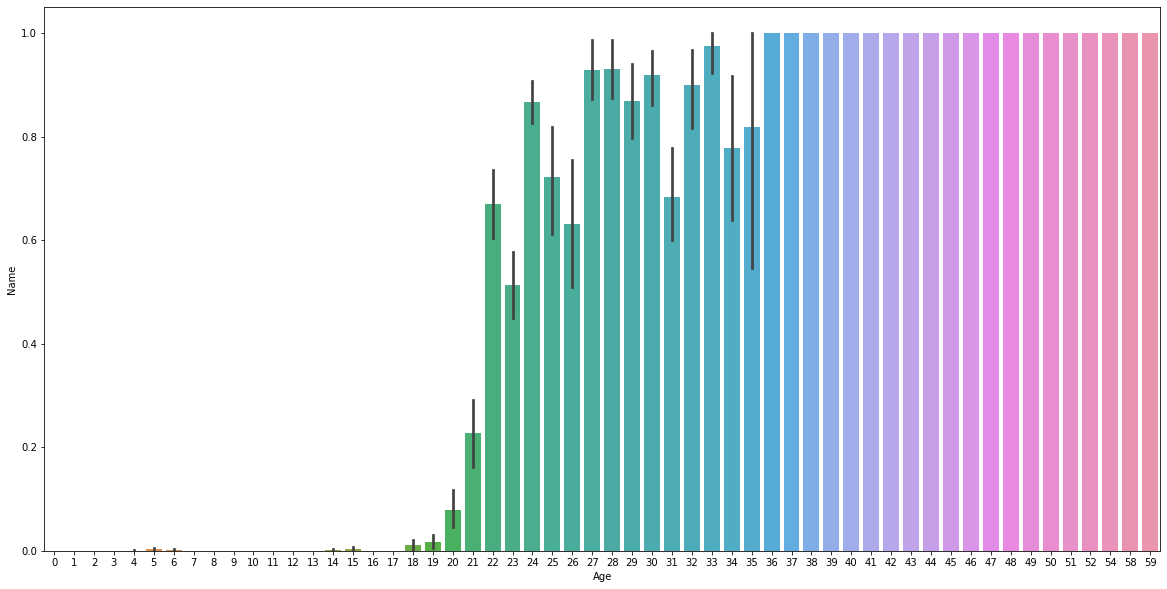

In [33]:
plt.figure(figsize = (20, 10))
sns.barplot(df_train["Age"].astype(int),df_train["Name"].isnull())

#### **情報不足の車両データを削除**

In [34]:
df_train = df_train.dropna()

#### **分析対象外データの削除**
現在新車で販売されている車両 ("Sale" = 1.0) は今回の調査目的と異なるため、対象から外します。

In [35]:
train = df_train[df_train["Sale"] != 1]
train

,Model_year,Seling_price,Model,Maker,Displacement,Color,Brightness,Door,Capacity,Length,Width,Height,Weight,Hybrid,Fuel,Limited,Age,Name,Name_year,Sale,System,Fuel_add,Hybrid_add,Gear,Transmission,Amount,List_price,Model_year_add,Displacement_add,Capacity_add,Door_add,Seat,Horsepower,Torque,Length_add,Width_add,Height_add,Wheelbase,Weight_add,Wheelsize,Wheelsize_d,Tiresize,Tiresize_d
0,2021.0,409.8,カムリ 2017年モデル WS レザーパッケージ E-Four,1.0,2500.0,4.0,1.0,4.0,5.0,4910.0,1840.0,1455.0,1680.000000,1.0,1.0,0.0,1.0,カムリ,カムリ 2017,0.0,4.0,1.0,1.0,0.0,1.0,2.0,465.000000,2020.000000,2487.0,5.0,4.0,2.0,131.0,221.0,4910.00,1840.0,1455.0,2825.0,1680.000000,18.0,0.0,235.0,0.0
1,2021.0,345.0,カムリ 2017年モデル WS,1.0,2500.0,4.0,1.0,4.0,5.0,4910.0,1840.0,1445.0,1570.000000,1.0,1.0,0.0,1.0,カムリ,カムリ 2017,0.0,1.0,1.0,1.0,0.0,1.0,83.0,385.000000,2019.500000,2487.0,5.0,4.0,2.0,131.0,221.0,4903.75,1840.0,1445.0,2825.0,1577.500000,17.0,0.0,215.0,0.0
2,2021.0,328.9,カムリ 2017年モデル X,1.0,2500.0,3.0,0.0,4.0,5.0,4885.0,1840.0,1445.0,1540.000000,1.0,1.0,0.0,1.0,カムリ,カムリ 2017,0.0,1.0,1.0,1.0,0.0,1.0,33.0,339.800000,2019.000000,2487.0,5.0,4.0,2.0,131.0,221.0,4885.00,1840.0,1445.0,2825.0,1546.000000,16.0,0.0,205.0,0.0
3,2021.0,377.0,カムリ 2017年モデル WS E-Four,1.0,2500.0,1.0,0.0,4.0,5.0,4910.0,1840.0,1455.0,1660.000000,1.0,1.0,0.0,1.0,カムリ,カムリ 2017,0.0,4.0,1.0,1.0,0.0,1.0,2.0,410.666667,2020.000000,2487.0,5.0,4.0,2.0,131.0,221.0,4910.00,1840.0,1455.0,2825.0,1660.000000,17.0,0.0,215.0,0.0
4,2021.0,360.0,カムリ 2017年モデル G レザーパッケージ,1.0,2500.0,4.0,1.0,4.0,5.0,4885.0,1840.0,1445.0,1600.000000,1.0,1.0,0.0,1.0,カムリ,カムリ 2017,0.0,1.0,1.0,1.0,0.0,1.0,93.0,428.600000,2019.000000,2487.0,5.0,4.0,2.0,131.0,221.0,4885.00,1840.0,1445.0,2825.0,1600.000000,18.0,0.0,235.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26966,2019.0,548.0,ES 2018年モデル 300h Version L,7.0,2500.0,1.0,0.0,4.0,5.0,4975.0,1865.0,1455.0,1730.000000,1.0,1.0,0.0,3.0,ES,ES 2018,0.0,1.0,1.0,1.0,0.0,1.0,93.0,712.666667,2019.666667,2487.0,5.0,4.0,2.0,131.0,221.0,4975.00,1865.0,1455.0,2870.0,1723.333333,18.0,0.0,235.0,0.0
26967,2019.0,508.0,ES 2018年モデル 300h F SPORT,7.0,2500.0,4.0,1.0,4.0,5.0,4975.0,1865.0,1455.0,1720.000000,1.0,1.0,0.0,3.0,ES,ES 2018,0.0,1.0,1.0,1.0,0.0,1.0,109.0,646.333333,2019.666667,2487.0,5.0,4.0,2.0,131.0,221.0,4975.00,1865.0,1455.0,2870.0,1713.333333,19.0,0.0,235.0,0.0
26968,2019.0,479.0,ES 2018年モデル 300h Version L,7.0,2500.0,4.0,1.0,4.0,5.0,4975.0,1865.0,1455.0,1730.000000,1.0,1.0,0.0,3.0,ES,ES 2018,0.0,1.0,1.0,1.0,0.0,1.0,93.0,712.666667,2019.666667,2487.0,5.0,4.0,2.0,131.0,221.0,4975.00,1865.0,1455.0,2870.0,1723.333333,18.0,0.0,235.0,0.0
26969,2018.0,529.8,ES 2018年モデル 300h Version L,7.0,2500.0,4.0,1.0,4.0,5.0,4975.0,1865.0,1455.0,1723.333333,1.0,1.0,0.0,4.0,ES,ES 2018,0.0,1.0,1.0,1.0,0.0,1.0,93.0,712.666667,2019.666667,2487.0,5.0,4.0,2.0,131.0,221.0,4975.00,1865.0,1455.0,2870.0,1723.333333,18.0,0.0,235.0,0.0


#### **不要カラムの削除**

In [36]:
train_drop = ["Model_year", "Maker","Sale", "Fuel_add", "Hybrid_add", "Model_year_add", "Displacement_add", "Capacity_add", "Door_add", "Length_add", "Width_add", "Height_add", "Weight_add"]
train = train.drop(train_drop, axis=1)

#### **新要素の追加**
販売が終了している車名のものを "End" としてデータセットに追加します。

In [37]:
train.loc[train["Name"].str.contains("マークX|シビック　タイプR|S660|NSX|S2000|インテグラ|GT-R|ランサーエボリューション|アクセラスポーツ|アクセラセダン|RX-8|WRX STI|WRX STI 4door|WRX STI 5door"), "End"] = 1
train.loc[~train["Name"].str.contains("マークX|シビック　タイプR|S660|NSX|S2000|インテグラ|GT-R|ランサーエボリューション|アクセラスポーツ|アクセラセダン|RX-8|WRX STI|WRX STI 4door|WRX STI 5door"), "End"] = 0

#### **価格変動率の算出**
"Fluctuation" ( 価格変動率 (%) )  = "Seling_price" ( 中古車販売価格 ) / "List_price" ( 定価 ) × 100 

In [38]:
train["Fluctuation"] = (train["Seling_price"] / train["List_price"]).round(2) * 100
train["Fluctuation"] = train["Fluctuation"].astype(int)
train = train.drop(["Seling_price"], axis=1)
train.to_pickle("./train.pkl")
train

,Model,Displacement,Color,Brightness,Door,Capacity,Length,Width,Height,Weight,Hybrid,Fuel,Limited,Age,Name,Name_year,System,Gear,Transmission,Amount,List_price,Seat,Horsepower,Torque,Wheelbase,Wheelsize,Wheelsize_d,Tiresize,Tiresize_d,End,Fluctuation
0,カムリ 2017年モデル WS レザーパッケージ E-Four,2500.0,4.0,1.0,4.0,5.0,4910.0,1840.0,1455.0,1680.000000,1.0,1.0,0.0,1.0,カムリ,カムリ 2017,4.0,0.0,1.0,2.0,465.000000,2.0,131.0,221.0,2825.0,18.0,0.0,235.0,0.0,0.0,88
1,カムリ 2017年モデル WS,2500.0,4.0,1.0,4.0,5.0,4910.0,1840.0,1445.0,1570.000000,1.0,1.0,0.0,1.0,カムリ,カムリ 2017,1.0,0.0,1.0,83.0,385.000000,2.0,131.0,221.0,2825.0,17.0,0.0,215.0,0.0,0.0,90
2,カムリ 2017年モデル X,2500.0,3.0,0.0,4.0,5.0,4885.0,1840.0,1445.0,1540.000000,1.0,1.0,0.0,1.0,カムリ,カムリ 2017,1.0,0.0,1.0,33.0,339.800000,2.0,131.0,221.0,2825.0,16.0,0.0,205.0,0.0,0.0,97
3,カムリ 2017年モデル WS E-Four,2500.0,1.0,0.0,4.0,5.0,4910.0,1840.0,1455.0,1660.000000,1.0,1.0,0.0,1.0,カムリ,カムリ 2017,4.0,0.0,1.0,2.0,410.666667,2.0,131.0,221.0,2825.0,17.0,0.0,215.0,0.0,0.0,92
4,カムリ 2017年モデル G レザーパッケージ,2500.0,4.0,1.0,4.0,5.0,4885.0,1840.0,1445.0,1600.000000,1.0,1.0,0.0,1.0,カムリ,カムリ 2017,1.0,0.0,1.0,93.0,428.600000,2.0,131.0,221.0,2825.0,18.0,0.0,235.0,0.0,0.0,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26966,ES 2018年モデル 300h Version L,2500.0,1.0,0.0,4.0,5.0,4975.0,1865.0,1455.0,1730.000000,1.0,1.0,0.0,3.0,ES,ES 2018,1.0,0.0,1.0,93.0,712.666667,2.0,131.0,221.0,2870.0,18.0,0.0,235.0,0.0,0.0,77
26967,ES 2018年モデル 300h F SPORT,2500.0,4.0,1.0,4.0,5.0,4975.0,1865.0,1455.0,1720.000000,1.0,1.0,0.0,3.0,ES,ES 2018,1.0,0.0,1.0,109.0,646.333333,2.0,131.0,221.0,2870.0,19.0,0.0,235.0,0.0,0.0,79
26968,ES 2018年モデル 300h Version L,2500.0,4.0,1.0,4.0,5.0,4975.0,1865.0,1455.0,1730.000000,1.0,1.0,0.0,3.0,ES,ES 2018,1.0,0.0,1.0,93.0,712.666667,2.0,131.0,221.0,2870.0,18.0,0.0,235.0,0.0,0.0,67
26969,ES 2018年モデル 300h Version L,2500.0,4.0,1.0,4.0,5.0,4975.0,1865.0,1455.0,1723.333333,1.0,1.0,0.0,4.0,ES,ES 2018,1.0,0.0,1.0,93.0,712.666667,2.0,131.0,221.0,2870.0,18.0,0.0,235.0,0.0,0.0,74


# **4. データの可視化（Matplotlib / Seaborn）**
###  **---- 販売中中古車の価格高騰率ランキング ----**
#### **▼ "Model" ランキング**

In [39]:
rank_model = train.groupby("Model", as_index=False)["Fluctuation"].mean()
rank_model.sort_values("Fluctuation", ascending=False).head(30)

,Model,Fluctuation
221,S2000 1999年モデル S2000 タイプ S (MT),179.100000
578,スープラ 1993年モデル RZ-S (MT),178.750000
577,スープラ 1993年モデル RZ-S,175.714286
579,スープラ 1993年モデル SZ,172.727273
102,LC コンバーチブル 2020年モデル LC500 Convertible Structur...,161.000000
242,WRX STI 2014年モデル EJ20 Final Edition,154.333333
580,スープラ 1993年モデル SZ (MT),144.750000
702,ランサーエボリューション 2007年モデル X RS,142.000000
697,ランサーエボリューション 2001年モデル IX MR GSR 4WD (MT),138.625000
696,ランサーエボリューション 2001年モデル IX GT 4WD (MT),133.333333


#### **▼ "Name_year" ランキング**

In [40]:
rank_name_y = train.groupby("Name_year", as_index=False)["Fluctuation"].mean()
rank_name_y.sort_values("Fluctuation", ascending=False).head(30)

,Name_year,Fluctuation
54,スープラ 1993,166.431034
3,GRヤリス 2020,124.375000
50,シビック タイプR 2017,119.043478
20,WRX STI 2014,113.041801
13,NSX 2017,108.111111
8,LC コンバーチブル 2020,105.266667
12,NSX 1990,104.583333
18,S660 2015,102.242261
69,レヴォーグ 2020,99.325397
49,シビック タイプR 2015,99.000000


#### **▼ "Name_year" ランキング**

In [41]:
rank_name = train.groupby("Name", as_index=False)["Fluctuation"].mean()
rank_name.sort_values("Fluctuation", ascending=False).head(30)

,Name,Fluctuation
3,GRヤリス,124.375000
31,スープラ,122.150000
17,WRX STI,113.041801
7,LC コンバーチブル,105.266667
10,NSX,105.140351
15,S660,102.242261
14,S2000,98.706107
4,GT-R,98.560440
23,インテグラ,96.344262
9,MAZDA3 ファストバック,89.627907


### **---- 各要素の相関 ----**

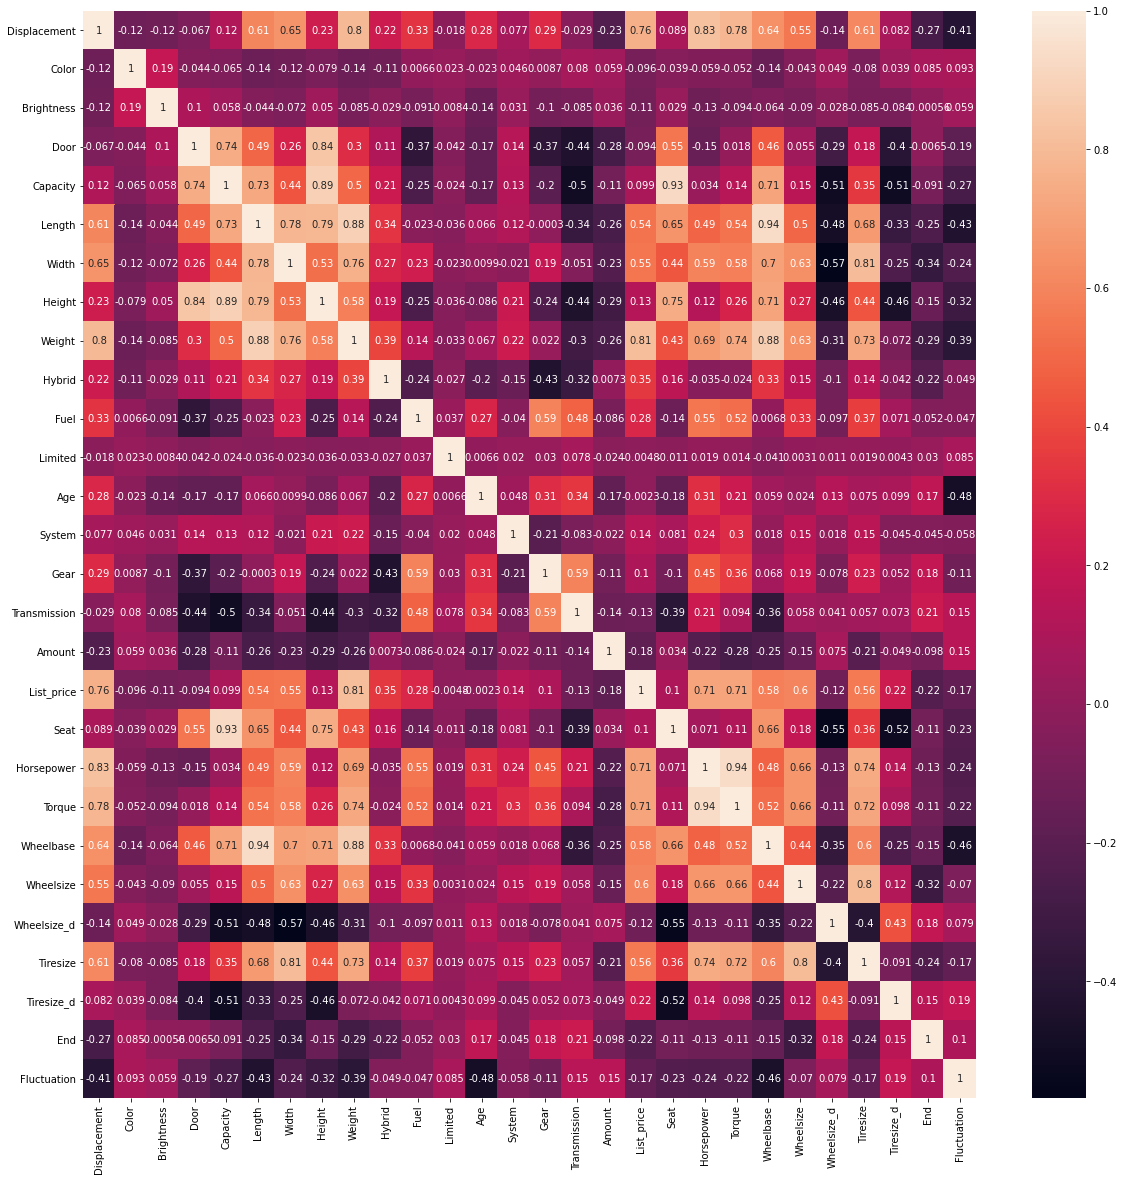

In [42]:
plt.figure(figsize = (20, 20))
sns.heatmap(train.corr(), annot=True)
plt.show()

#### **データの各列の概要**
|データ列名|意味|変数の種類|備考|
|:---|:---|:---|:---|
|Displacement|排気量|量的|（単位 : cc）|
|Color|ボディカラー|カテゴリ| 0 :その他 、 1 : 黒 、 2 : グレー 、 3 : シルバー 、 4 : 白 、 5 : 赤 、 6 : 青 、 7 : 黄 |
|Brightness|光輝材|カテゴリ| 0 : ソリッド 、 1 : パール 、 2 : メタリック |
|Door|ドア数|量的|（単位 : 枚）|
|Capacity|収容人数|量的|（単位 : 人）|
|Length|全長|量的|（単位 : m）|
|Width|全幅|量的|（単位 : m）|
|Height|全高|量的|（単位 : m）|
|Weight|重量|量的|（単位 : kg）|
|Hybrid|ハイブリッド|カテゴリ |0 : ガソリン 、 1 : ハイブリッド |
|Fuel|燃料|カテゴリ| 1 : レギュラー 、 2 : ハイオク 、 3 : ディーゼル |
|Limited|バージョン|カテゴリ| 0 : 通常版 、 1 : 限定版 |
|Age|経過年数|量的|（単位 : 年）|
|System|駆動方式|カテゴリ| 1 :FF 、 2 : FR 、 3 : MR  、 4 : RR |
|Gear|ギア数|量的||
|Transmission|トランスミッション|カテゴリ| 1 : CVT 、 2 : AT 、 3 : DCT 、 4 : MT |
|Amount|掲載数|量的|（単位 : 件）|
|List_price|定価|量的|（単位 : 円）|
|Seat|シート列数|量的|（単位 : 列）|
|Horsepower|最高出力|量的|（単位 : PS）|
|Torque|最大トルク|量的|（単位 : N・m）|
|Wheelbase|ホイールベース|量的|（単位 : m）|
|Wheelsize|ホイールサイズ 前|量的|（単位 : インチ）|
|Wheelsize_d|ホイールサイズ 前後差|量的|（単位 : インチ）|
|Tiresize|タイヤサイズ 前|量的|（単位 : mm）|
|Tiresize_d|タイヤサイズ 前後差|量的|（単位 : mm）|
|End|車名存続の是非|カテゴリ| 0 : 存続 、　1 : 消滅 |
|Fluctuation|価格変動率|量的|（単位 : %）|

### **---- 特徴ごとの個別調査 ----**
"Fluctuation" と相関関係が強そうな要素を優先的に調査します。  
  
"Color", "Limited", "Transmission", "Amount", "Tiresize_d", "End"
#### **Seaborn 表示設定**

In [43]:
sns.set_theme(style="darkgrid")
sns.set_palette("viridis", 8, 1)

#### **価格変動率 : "Fluctuation"**
外れ値を確認します。

/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Fluctuation'>

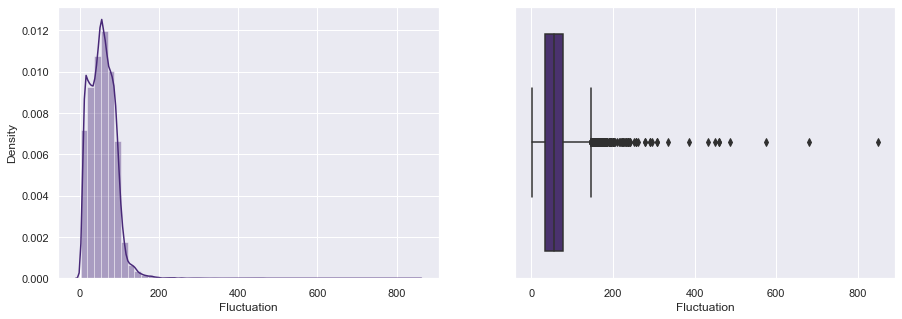

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(train["Fluctuation"], ax=ax[0])
sns.boxplot(train["Fluctuation"], ax=ax[1])

価格変動率が約8倍という極端に高い数値を検出しています。   
ただし値としてあり得るので、今回は絞り込みを行いません。
  
#### **色 : "Color"  /  光輝材 : "Brightness"**

/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an e

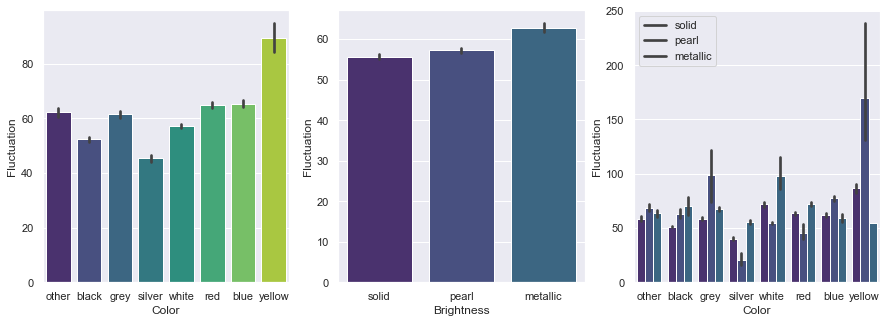

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(train["Color"], train["Fluctuation"], ax=ax[0]).set_xticklabels(["other", "black", "grey", "silver", "white", "red", "blue", "yellow"])
sns.barplot(train["Brightness"], train["Fluctuation"], ax=ax[1]).set_xticklabels(["solid", "pearl", "metallic"])
sns.barplot(train["Color"], train["Fluctuation"], hue=train["Brightness"], ax=ax[2]).set_xticklabels(["other", "black", "grey", "silver", "white", "red", "blue", "yellow"])
ax[2].legend(["solid", "pearl", "metallic"])

全体で見ると、以下の要素に価格高騰要因があると思われます。
  
色 : 黄色  
光輝材 : メタリック
  
しかし価格変動率を色・光輝材で集計すると、黄色のメタリックはそれほど高騰していないことが分かります。  
高い数値を示したのが以下の通りです。  
  
・イエローパール  
・グレーパール  
・ホワイトメタリック  
  
また色・光輝材それぞれの中古車掲載数をグラフに追記します。

/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


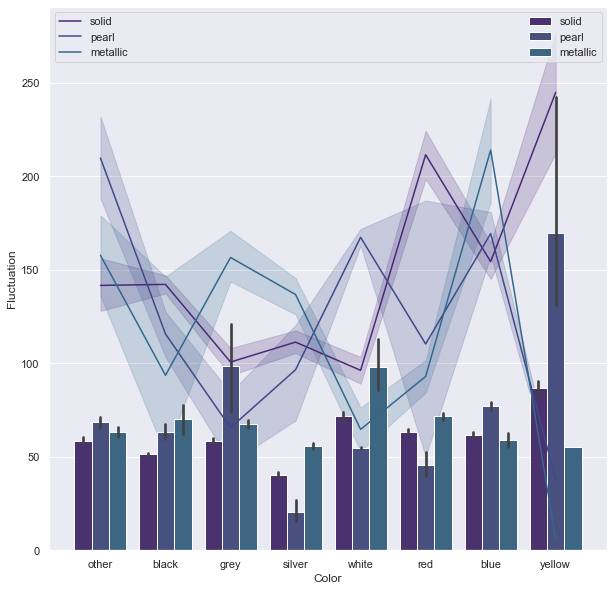

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.barplot(train["Color"], train["Fluctuation"], 
                 hue=train["Brightness"].replace({0:"solid", 1:"pearl", 2:"metallic"}), 
                 hue_order=["solid", "pearl", "metallic"]).set_xticklabels(["other", "black", "grey", "silver", "white", "red", "blue", "yellow"])
ax = sns.lineplot(train["Color"], train["Amount"], 
                  hue=train["Brightness"].replace({0:"solid", 1:"pearl", 2:"metallic"}),
                  hue_order=["solid", "pearl", "metallic"]).legend(ncol=2, mode="expand")

イエローパールの掲載数が極端に少ないことが分かります。  
情報数が少ないため、高騰要因だと判断するのは難しいと言えます。  
結果として以下の条件が高騰要因と思われます。  
  
色 / 光輝材   
<font color="MediumVioletRed">
・グレー / パール</font>  
<font color="MediumVioletRed">
・ホワイト / メタリック</font>
#### **バージョン : "Limited"**

/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'normal'), Text(1, 0, 'limited')]

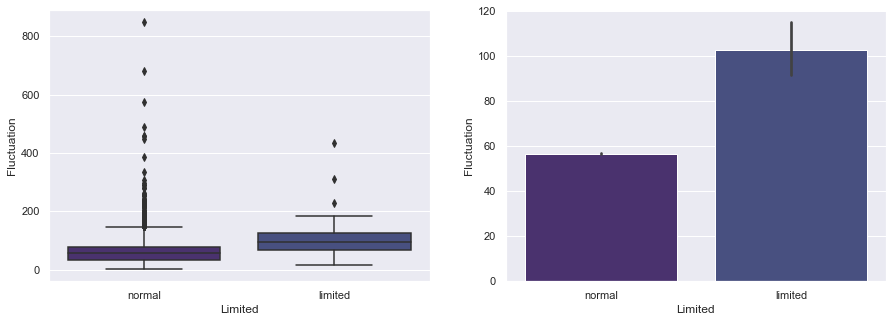

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(train["Limited"], train["Fluctuation"], ax=ax[0]).set_xticklabels(["normal", "limited"])
sns.barplot(train["Limited"], train["Fluctuation"], ax=ax[1]).set_xticklabels(["normal", "limited"])

全体で見ると、限定車の方が価格が高騰しているように見えます。  
しかしこのデータには、限定車が存在しないモデルも含まれています。  
限定車の存在するモデルを抽出し、その通常版と限定版で変動率を比較します。

/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'normal'), Text(1, 0, 'limited')]

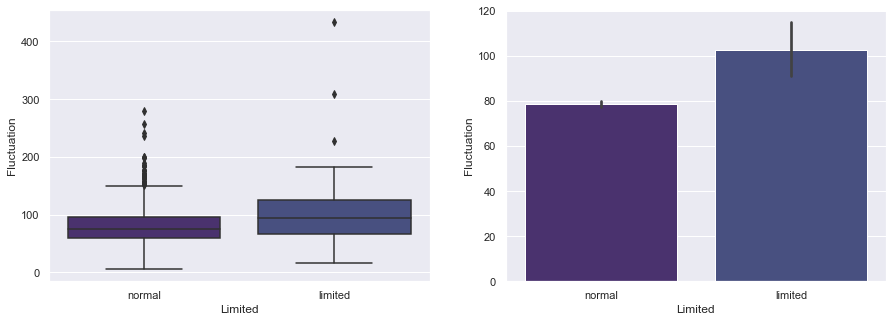

In [48]:
limited_model = train["Model"][train["Limited"]==1].unique()
train_limited = train[train["Model"].isin(limited_model)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(train_limited["Limited"], train_limited["Fluctuation"], ax=ax[0]).set_xticklabels(["normal", "limited"])
sns.barplot(train_limited["Limited"], train_limited["Fluctuation"], ax=ax[1]).set_xticklabels(["normal", "limited"])

全体でのデータ比較より若干価格差が縮まりましたが、やはり限定車の方が価格が高騰しているようです。  
以下の特徴に価格高騰の要因があると言えます。  
  
バージョン  
<font color="MediumVioletRed">
・限定車
</font>

#### **トランスミッション : "Transmission"  /  燃料 : "Fuel"**

/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an e

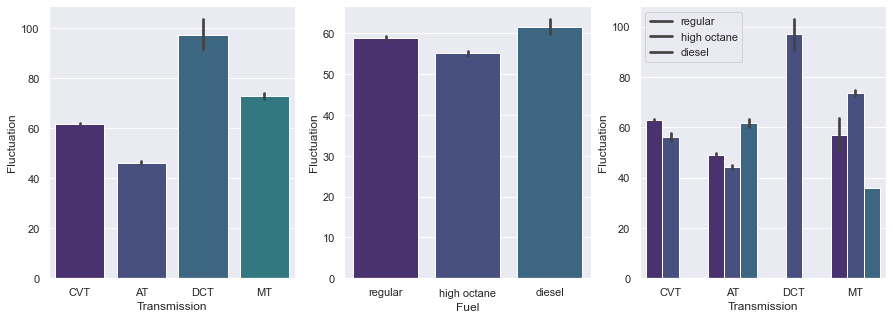

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(train["Transmission"], train["Fluctuation"], ax=ax[0]).set_xticklabels(["CVT", "AT", "DCT", "MT"])
sns.barplot(train["Fuel"], train["Fluctuation"], ax=ax[1]).set_xticklabels(["regular", "high octane", "diesel"])
sns.barplot(train["Transmission"], train["Fluctuation"], hue=train["Fuel"], ax=ax[2]).set_xticklabels(["CVT", "AT", "DCT", "MT"])
ax[2].legend(["regular", "high octane", "diesel"])

トランスミッションの比較では、"DCT"(デュアルクラッチトランスミッション）の変動率が最も高い数値を示しています。  
燃料の比較では最も高いのはディーゼル、最も低いのはハイオクとなっています。  
しかし２つの要素を同時に集計すると、以下の特徴が高い数値を示しています。  
  
トランスミッション / 燃料  
<font color="MediumVioletRed">
・デュアルクラッチトランスミッション / ハイオク</font>  
<font color="MediumVioletRed">
・マニュアル / ハイオク</font>

#### **経過年数 : "Age"  /  掲載数 : "Amount"**

/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Amount', ylabel='Fluctuation'>

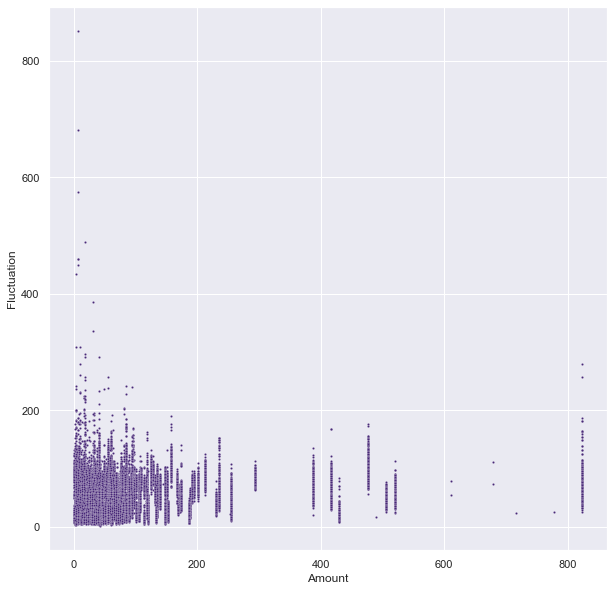

In [50]:
plt.figure(figsize = (10, 10))
sns.scatterplot(train["Amount"], train["Fluctuation"], s=5)

掲載数と価格変動率の関係を示しました。  
掲載数と価格変動率の相関は比較的高い数値であったが、一見どのような関係があるのか分かりません。  
そこで経過年数を軸として掲載数を集計し、さらに経過年数と価格変動率の推移を見てみます。

/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age', ylabel='Fluctuation'>

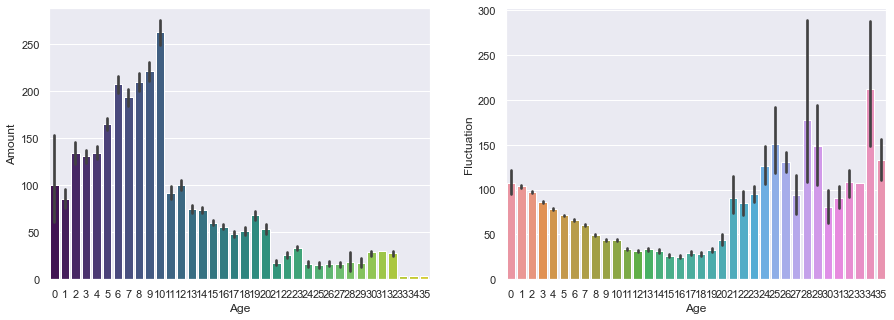

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(train["Age"].astype(int), train["Amount"], palette="viridis", ax=ax[0])
sns.barplot(train["Age"].astype(int), train["Fluctuation"], ax=ax[1])

経過年数が上昇するとともに掲載数も増えていきますが、10年目を境に下降に転じています。  
また経過年数と価格変動率の関係を示した右のグラフをご覧下さい。  
年数が経つにつれ価格が下がっていきますが、15年目付近を境に上昇に転じています。  
  
この２つのグラフはほとんど逆の動きを示しています。  
つまり経過年数が10年を超えてくると市場流通数も減少していき、それに伴って価格が高騰してくることを示しています。  
したがって以下の特徴に価格高騰要因があると考えられます。  
  
経過年数  /  掲載数  
<font color="MediumVioletRed">
・経過年数10年以上 / 掲載数少数</font>

#### **タイヤサイズ前後差 : "Tiresize_d"**

/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Tiresize_d', ylabel='Fluctuation'>

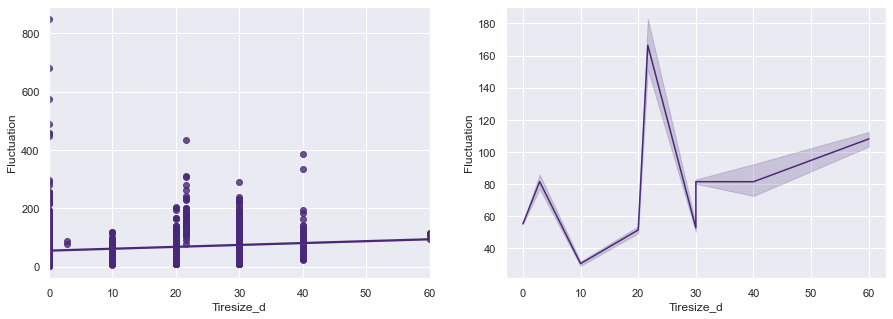

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.regplot(train["Tiresize_d"], train["Fluctuation"], ax=ax[0])
sns.lineplot(train["Tiresize_d"], train["Fluctuation"], ax=ax[1])

タイヤサイズの前後差が大きいほど価格が高騰しているように見えますが、このグラフからはっきりとそう言い切ることはできません。  
この比較はタイヤサイズ前後差の大小によるものですが、前後差の有無による比較を見てみます。

/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


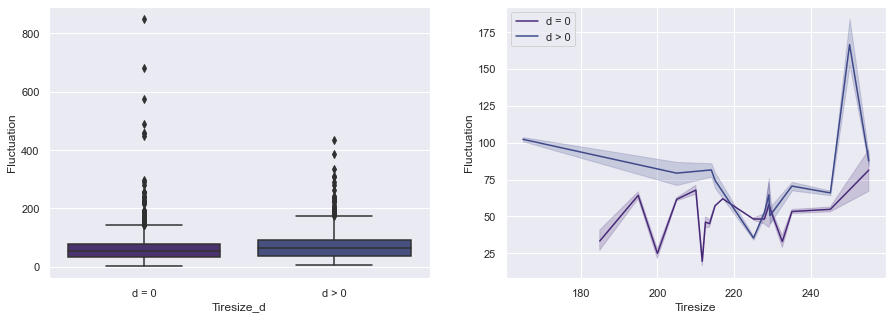

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=train["Tiresize_d"]>0, y=train["Fluctuation"], ax=ax[0]).set_xticklabels(["d = 0", "d > 0"])
sns.lineplot(train["Tiresize"], train["Fluctuation"], hue=train["Tiresize_d"]>0, ax=ax[1])
ax[1].legend(["d = 0", "d > 0"])

箱ひげ図を見ると、タイヤサイズ前後差のある車の方が高騰しているように見えます。  
さらに同じタイヤサイズで比較してみると、やはり前後差のある車の方が高い数値を示しています。  
したがって以下の特徴に価格高騰要因があるようです。  
  
タイヤサイズ前後差  
<font color="MediumVioletRed">
・タイヤサイズ前後差あり</font>

#### **車名消滅 : "End"**

/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an e

<AxesSubplot:xlabel='Transmission', ylabel='Fluctuation'>

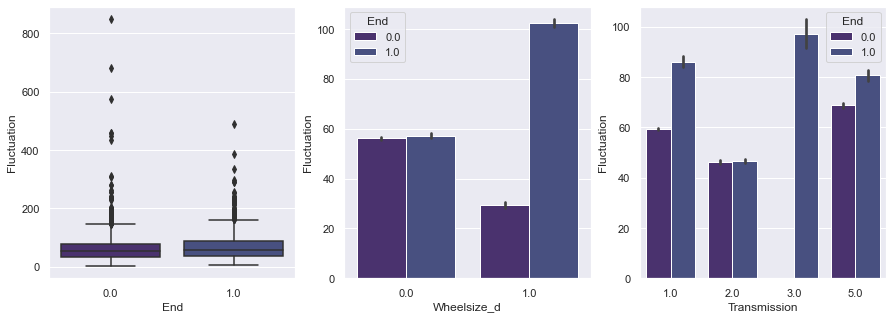

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(train["End"], train["Fluctuation"], ax=ax[0])
sns.barplot(train["Wheelsize_d"], train["Fluctuation"], hue=train["End"], ax=ax[1])
sns.barplot(train["Transmission"], train["Fluctuation"], hue=train["End"], ax=ax[2])

全体で見ると、現在存在していない車名は現役の車名とそこまで変化がないように見えます。  
しかし"End"と相関の強かった"Wheelsize_d"・"Transmission"を軸に集計すると、いずれも現在存在していない車名の方が価格が高騰していることが分かります。  
したがって以下の特徴に価格高騰要因があると思われます。  
  
車名存続  
<font color="MediumVioletRed">
・車名消滅
</font>

***
# **5. モデルの構築（scikit-learn）**
### **---- 学習データの分割 ----**
#### **数値ではないデータの削除**

In [55]:
train_columns = ["Model", "Name", "Name_year"]
train = train.drop(train_columns, axis=1)

#### **データの分割（訓練用 / テスト用）**

In [56]:
tr_train, tr_test = train_test_split(train, test_size=0.3, random_state=1234)

#### **データの分割（説明変数 / 目的変数）**

In [57]:
tr_train_X = tr_train[train.columns[:-1]]
tr_train_Y = tr_train[train.columns[-1]]
tr_test_X = tr_test[train.columns[:-1]]
tr_test_Y = tr_test[train.columns[-1]]

### **---- 機械学習モデルの構築 ----**
#### **決定木の実装**

In [58]:
model = tree.DecisionTreeRegressor()

model.fit(tr_train_X, tr_train_Y)

predict = model.predict(tr_test_X).astype(int)

print("判別率: {}".format(metrics.r2_score(predict, tr_test_Y)))

判別率: 0.6944625806391438


In [59]:
model_mse = mean_squared_error(predict, tr_test_Y)
model_rmse = np.sqrt(model_mse)
print("誤差: {}".format(model_rmse))

誤差: 18.241165826748965


#### **ランダムフォレストの実装**

In [60]:
model = RandomForestRegressor(n_estimators=100)

model.fit(tr_train_X, tr_train_Y)

predict = model.predict(tr_test_X).astype(int)

print("判別率: {}".format(metrics.r2_score(predict, tr_test_Y)))

判別率: 0.7484593717459668


In [61]:
model_mse = mean_squared_error(predict, tr_test_Y)
model_rmse = np.sqrt(model_mse)
print("誤差: {}".format(model_rmse))

誤差: 15.503480528472696


### **---- モデルの検証 ----**  
#### **K-分割交差検証の実装**

In [62]:
kf = KFold(n_splits=5, random_state=30, shuffle=True)

x = train[train.columns[:-1]]
y = train["Fluctuation"]

cv_result = cross_val_score(model, x, y, cv=kf)

print("cv: {}".format(cv_result))
print("平均精度: {}".format(cv_result.mean()))

cv: [0.79211747 0.82193442 0.82037251 0.78840334 0.82289411]
平均精度: 0.8091443706696522


#### **グリッドサーチの実装**

In [63]:
param = {"n_estimators": range(100, 1000, 100)}
GS_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=0),
                     param_grid=param,
                     verbose=True,
                     scoring = "r2",
                     cv=5)
GS_rf.fit(x, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 24.7min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid={'n_estimators': range(100, 1000, 100)}, scoring='r2',
             verbose=True)

In [64]:
GS_rf.best_params_

{'n_estimators': 200}

In [65]:
GS_rf_pred = GS_rf.predict(x)
GS_rf_r2 = metrics.r2_score(y, GS_rf_pred)
print("判別率: {}".format(GS_rf_r2))

判別率: 0.9190124985248976


In [66]:
GS_rf_mse = mean_squared_error(y, GS_rf_pred)
GS_rf_rmse = np.sqrt(GS_rf_mse)
print("誤差: {}".format(GS_rf_rmse))

誤差: 9.21348646505951


予測精度が約91％まで向上し、誤差が約9.2まで減少しました。  
このモデルを将来予測用として採用します。　　

***
# **6. モデルの適用**
### **---- テストデータの作成 ----**
現在新車で販売中の車両（"Sale"=1）のデータを抽出

In [67]:
df_test = df_spec_add[df_spec_add["Sale"]==1]

### **---- テストデータの処理 ----**
#### **文字列データの削除**
"Model_number", "Model", "Name_year", "Name"

In [68]:
test = df_test.drop(train_columns, axis=1)
test = test.drop(["Model_year", "Sale"], axis=1)

#### **不足情報の追加**
#### **"Color" / "Brightness"**
ボディカラー : グレー  
光輝材 : パール

In [69]:
test["Color"] = 2
test["Brightness"] = 1

#### **予測データの設定**
今回は5年後、10年後、20年後の価格を予測します。

In [70]:
test_5 = test.copy(deep=True)
test_10 = test.copy(deep=True)
test_20 = test.copy(deep=True)

#### **▼ 5年後**
経過年数 : 5年  
車名存続の是非 : 存続  
バージョン : 通常版  
掲載数 : 現在の1.5倍

In [71]:
test_5["Age"] = 5
test_5["End"] = 0
test_5["Limited"] = 0
test_5["Amount"] = test_5["Amount"]*1.5

#### **▼ 10年後**
経過年数 : 10年  
車名存続の是非 : 消滅  
バージョン : 通常版  
掲載数 : 現在の2倍

In [72]:
test_10["Age"] = 10
test_10["End"] = 1
test_10["Limited"] = 0
test_10["Amount"] = test_10["Amount"]*2

#### **▼ 20年後**
経過年数 : 20年  
車名存続の是非 : 消滅  
バージョン : 限定版  
掲載数 : 現在の0.5倍

In [73]:
test_20["Age"] = 20
test_20["End"] = 1
test_20["Limited"] = 1
test_20["Amount"] = test_20["Amount"]*0.5

### **---- 機械学習モデルの適用 ----**
#### **最高性能モデルでの学習**

In [74]:
model = GS_rf.best_estimator_

model.fit(train[train.columns[:-1]], train[train.columns[-1]])

RandomForestRegressor(n_estimators=200, random_state=0)

#### **モデルの適用**

In [75]:
test_5_prediction = model.predict(test_5)

In [76]:
test_10_prediction = model.predict(test_10)

In [77]:
test_20_prediction = model.predict(test_20)

#### **将来価格予測**

In [78]:
result = pd.DataFrame({"Model":df_test["Model"], "5_years": test_5_prediction, "10_years": test_10_prediction, "20_years": test_20_prediction})
result

,Model,5_years,10_years,20_years
54,BRZ 2021年モデル R,103.514780,103.514780,104.471411
55,BRZ 2021年モデル R (MT),110.348172,110.348172,112.008137
56,BRZ 2021年モデル S,103.514780,103.514780,104.471411
57,BRZ 2021年モデル S (MT),110.348172,110.348172,112.008137
62,GRヤリス 2020年モデル RS,110.065545,110.065545,110.674378
63,GRヤリス 2020年モデル RZ,110.445819,110.445819,112.105784
65,GRヤリス 2020年モデル RZ High performance,110.445819,110.445819,112.105784
73,GT-R 2007年モデル GT-R NISMO Special edition,108.737417,108.737417,109.858048
74,GT-R 2007年モデル GT-R Premium Edition T-spec,103.612427,103.612427,104.569058
78,GT-R 2007年モデル GT-R Track Edition Engineered by...,103.448427,103.448427,104.569058


### **---- 予測に効いた重要な特徴 ----**

/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


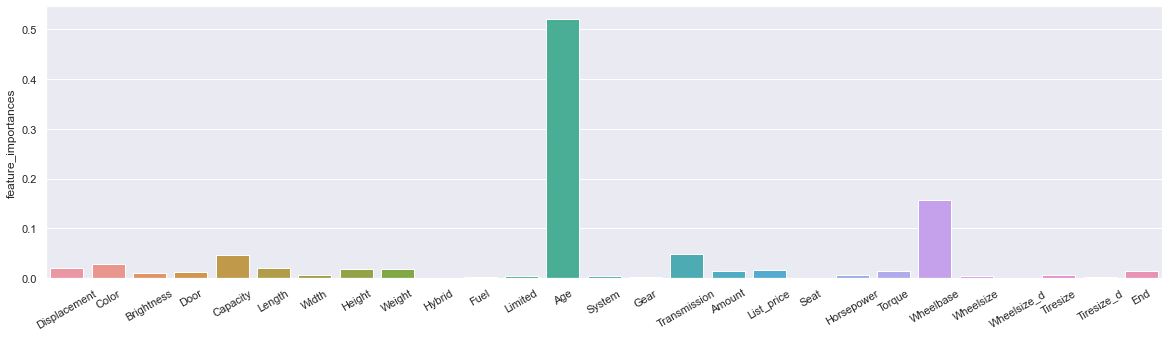

In [86]:
plt.figure(figsize=(20, 5))
feature_importances = pd.DataFrame({"feature_importances": model.feature_importances_})
ax = sns.barplot(tr_train_X.columns, feature_importances["feature_importances"]).set_xticklabels(ax.get_xticklabels(),rotation = 30)

やはり"Age"（経過年数）が最も予測に貢献していました。  
これまであまり着目してこなかった"Wheelbase"（ホイールベース）が、想像以上に貢献していたことに驚愕しました。  
  
#### **総評**
ここまでの予測プロジェクトは、まだ信頼できるものとは言い難いです。  
内容についてご意見・ご感想をお寄せ頂けると幸いです。  
フィードバックを得てプロジェクトをよりインパクトのあるものへと繰り返し実行していく所存です。  
  
最後までご覧頂きありがとうございました。